In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, time, json
import pandas as pd
from openai import OpenAI
from tqdm.auto import tqdm
import spacy

import sys

sys.path.append("../")
import os

import logging
from src.utils import logging_utils
from src.utils import env_utils
from src import functional

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")


client = OpenAI(
    api_key=os.getenv("OPENAI_KEY"),
)

MODEL_NAME = "gpt-4o"

/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2024-08-28 00:48:23 __main__ INFO     torch.__version__='2.3.1', torch.version.cuda='12.1'
2024-08-28 00:48:23 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=1, torch.cuda.get_device_name()='NVIDIA RTX A6000'
2024-08-28 00:48:23 __main__ INFO     transformers.__version__='4.43.3'
2024-08-28 00:48:23 httpx DEBUG    load_ssl_context verify=True cert=None trust_env=True http2=False
2024-08-28 00:48:23 httpx DEBUG    load_verify_locations cafile='/usr/lib/ssl/certs/ca-certificates.crt'


In [3]:
import torch

from nnsight import LanguageModel
from src.models import ModelandTokenizer

# model_key = "meta-llama/Meta-Llama-3-8B"
model_key = "meta-llama/Meta-Llama-3-8B-Instruct"
# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-2-27b-it"
# model_key = "Qwen/Qwen2-7B"

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.float16,
)

2024-08-28 00:11:32 accelerate.utils.modeling INFO     We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]

2024-08-28 00:11:37 src.models INFO     loaded model </home/local_arnab/Codes/00_MODEL/meta-llama/Meta-Llama-3-8B-Instruct> | size: 15316.516 MB | dtype: torch.float16 | device: cuda:0


In [4]:
from src.utils.typing import TokenizerOutput
from src.functional import get_module_nnsight, untuple, get_hs, PatchSpec
from typing import Literal
from dataclasses import dataclass
from src.functional import free_gpu_cache


#! the clean here actually stands for **corrupt* in the causal tracing
def attribution_patching(
    mt: ModelandTokenizer,
    clean_inputs: TokenizerOutput,
    patches: PatchSpec | list[PatchSpec],
    interested_locations: list[tuple[str, int]],
    ans_token_idx: int,
    metric: Literal["logit", "proba"] = "proba",
    resolution: int = 10,
    intermediate_point_sample: Literal["linear", "non-linear"] = "non-linear",
) -> float:
    if "offset_mapping" in clean_inputs:
        clean_inputs.pop("offset_mapping")
    if isinstance(patches, PatchSpec):
        patches = [patches]

    clean_states = get_hs(
        mt=mt, input=clean_inputs, locations=interested_locations, return_dict=True
    )
    patched_states = get_hs(
        mt=mt,
        input=clean_inputs,
        locations=interested_locations,
        patches=patches,
        return_dict=True,
    )
    free_gpu_cache()

    scan = True

    @dataclass
    class IGCache:
        h: torch.Tensor
        grad: torch.Tensor

        # def __post_init__(self):
        #     assert self.h.shape == self.grad.shape

    def is_an_attn_head(module_name) -> bool | tuple[int, int]:
        attn_id = mt.attn_module_name_format.split(".")[-1]
        if attn_id not in module_name:
            return False
        if module_name.endswith(attn_id):
            return False

        head_id = module_name.split(".")[-1]
        layer_id = ".".join(module_name.split(".")[:-1])

        return layer_id, int(head_id)

    approx_IE = {loc: [] for loc in interested_locations}
    alphas = torch.linspace(0, 1, resolution + 1)

    for a_idx in tqdm(range(len(alphas) - 1)):
        alpha = alphas[a_idx]

        with mt.trace(clean_inputs, scan=scan, validate=scan) as tracer:
            # patching
            for patch in patches:
                module_name, tok_idx = patch.location
                patch_module = get_module_nnsight(mt, module_name)

                assert (
                    isinstance(patch.clean, torch.Tensor)
                    and patch.clean.shape == patch.patch.shape
                )
                mid_point = (1 - alpha) * patch.clean + alpha * patch.patch
                mid_point = (
                    mid_point.to(mt.device)
                    if not mid_point.device == mt.device
                    else mid_point
                )
                mid_point.retain_grad = True

                patch_module.output[0, tok_idx, :] = mid_point

            # cache the interested hidden states
            for loc in interested_locations:
                module_name, tok_idx = loc

                if is_an_attn_head(module_name) == False:
                    module = get_module_nnsight(mt, module_name)
                    # tracer.apply(logger.debug, f"{module_name} => {module.input.shape}")
                    cur_output = (
                        module.output.save()
                        if ("mlp" in module_name or module_name == mt.embedder_name)
                        else module.output[0].save()
                    )  #! nnsight quirk => to get the grad of a reference tensor, you can't index it
                    # if "mlp" in module_name:
                    #     cur_output = module.input[0][0].save()
                    # elif "attn" in module_name:
                    #     cur_output = module.input[1]["hidden_states"].save()
                    # else:
                    #     cur_output = module.input[0][0].save()

                    # tracer.apply(logger.debug, cur_output.shape)
                    approx_IE[loc].append(
                        IGCache(
                            h=cur_output[0, tok_idx, :].save(),
                            grad=cur_output.grad[0, tok_idx, :].save(),
                        )
                    )
                else:
                    attn_module_name, head_idx = is_an_attn_head(module_name)
                    o_proj_name = attn_module_name + ".o_proj"
                    head_dim = mt.n_embd // mt.model.config.num_attention_heads
                    o_proj = get_module_nnsight(mt, o_proj_name)
                    cur_input = o_proj.input[0][0][
                        :, :, head_idx * head_dim : (head_idx + 1) * head_dim
                    ].save()
                    # tracer.apply(logger.debug, cur_input.size())

                    approx_IE[loc].append(
                        IGCache(
                            h=cur_input[0, tok_idx, :].save(),
                            grad=o_proj.input[0][0]
                            .grad[
                                0,
                                tok_idx,
                                head_idx * head_dim : (head_idx + 1) * head_dim,
                            ]
                            .save(),
                        )
                    )

            #! nnsight quirk => backward() has to be called later than grad.save() to populate the proxies
            if metric == "logit":
                v = mt.output.logits[0][-1][ans_token_idx]
            elif metric == "proba":
                v = mt.output.logits[0][-1].softmax(dim=-1)[ans_token_idx]
            else:
                raise ValueError(f"unknown {metric=}")
            v.backward()

        mt._model.zero_grad()
        scan = False
        free_gpu_cache()

    grads = {
        loc: sum([ig.grad for ig in approx_IE[loc]]) / resolution
        for loc in interested_locations
    }

    if intermediate_point_sample == "linear":
        approx_IE = {
            loc: torch.dot(grad, patched_states[loc] - clean_states[loc]).item()
            for loc, grad in grads.items()
        }
    elif intermediate_point_sample == "non-linear":
        for loc in interested_locations:
            ie_approx = 0
            for a_idx in range(len(alphas) - 1):
                grad = approx_IE[loc][a_idx].grad
                h_0 = approx_IE[loc][a_idx].h
                h_next = (
                    approx_IE[loc][a_idx + 1].h
                    if a_idx < len(alphas) - 2
                    else patched_states[loc]
                )

                ie_approx += torch.dot(grad, h_next - h_0).item()

            approx_IE[loc] = ie_approx
    else:
        raise ValueError(f"unknown {intermediate_point_sample=}")

    return approx_IE

In [5]:
from src.functional import prepare_input, guess_subject
from src.functional import find_token_range, get_hs
from typing import Optional


def get_h_at_subj(
    mt: ModelandTokenizer,
    layer: str | list[str],
    prompt: str | TokenizerOutput,
    subj: Optional[str] = None,
    input: Optional[TokenizerOutput] = None,
) -> torch.Tensor:
    if subj is None:
        subj = guess_subject(prompt)
        logger.warning(f"no subj provided, guessed {subj=}")
    else:
        assert subj in prompt, f"{subj=} not in {prompt=}"

    skip_prepare_input = input is not None and "offset_mapping" in input
    if not skip_prepare_input:
        logger.debug(f"preparing input for prompt: {prompt}")
        input = prepare_input(prompts=prompt, tokenizer=mt, return_offsets_mapping=True)
    offset_mapping = input.pop("offset_mapping")[0]
    subj_range = find_token_range(
        string=prompt,
        substring=subj,
        tokenizer=mt.tokenizer,
        offset_mapping=offset_mapping,
    )
    subj_ends = subj_range[1] - 1

    logger.debug(
        f'{subj=} => {subj_ends=} | "{mt.tokenizer.decode(input["input_ids"][0][subj_ends])}"'
    )

    return get_hs(mt=mt, input=input, locations=[(l, subj_ends) for l in layer])

In [6]:
from src.dataset import load_bridge_relation, BridgeDataset

relation_icq = load_bridge_relation(
    # file_name="/home/local_arnab/Codes/retrieval/data/bridge_dataset/cleaned/movie_actor.json"
    # file_name="/home/local_arnab/Codes/retrieval/data/bridge_dataset/cleaned/architect_building.json"
    file_name="/home/local_arnab/Codes/retrieval/data/bridge_dataset/cleaned/sport_players.json"
)

dataset = BridgeDataset(relations=[relation_icq])

2024-08-28 00:11:37 src.dataset INFO     initialized bridge relation sport_players with 23 examples
2024-08-28 00:11:37 src.dataset INFO     initialized bridge dataset with 1 relations and 22 examples


In [7]:
for idx, sample in enumerate(dataset.examples):
    print(idx, "=>", sample)

0 => badminton - a sport where both Lin Dan and Lee Chong Wei are known for.
1 => athletics - a sport where both Usain Bolt and Carl Lewis are known for.
2 => surfing - a sport where both Kelly Slater and Andy Irons are known for.
3 => basketball - a sport where both Michael Jordan and LeBron James are known for.
4 => hockey - a sport where both Wayne Gretzky and Mario Lemieux are known for.
5 => baseball - a sport where both Babe Ruth and Hank Aaron are known for.
6 => gymnastics - a sport where both Simone Biles and Nadia Comaneci are known for.
7 => rugby - a sport where both Jonah Lomu and Richie McCaw are known for.
8 => volleyball - a sport where both Karch Kiraly and Giba are known for.
9 => table tennis - a sport where both Ma Long and Zhang Jike are known for.
10 => american football - a sport where both Tom Brady and Peyton Manning are known for.
11 => skiing - a sport where both Lindsey Vonn and Mikaela Shiffrin are known for.
12 => cycling - a sport where both Lance Armstro

In [8]:
clean_idx = 11
patch_idx = 5
from src.dataset import BridgeSample


clean_icq = dataset[clean_idx]
patch_icq = dataset[patch_idx]

# patch_icq = (patch_icq[0].replace(
#     "Michael Vaughan", "Ricky Ponting",
# ).replace(
#     "Sourav Ganguly", "Rahul Dravid",
# ), patch_icq[1])

dct = dataset.examples[patch_idx].to_dict()
# dct["entity_pair"] = ["Ricky Ponting", "Rahul Dravid"]

dataset.examples[patch_idx] = BridgeSample.from_dict(dct)

print(f"{dataset.icl_examples=}")
print(f"{dataset.examples[clean_idx]=}")
print(f"{dataset.examples[patch_idx]=}")

dataset.icl_examples=[BridgeSample(bridge='boxing', entity_pair=['Muhammad Ali', 'Mike Tyson'], description='boxing - a sport where both Muhammad Ali and Mike Tyson are known for.')]
dataset.examples[clean_idx]=BridgeSample(bridge='skiing', entity_pair=['Lindsey Vonn', 'Mikaela Shiffrin'], description='skiing - a sport where both Lindsey Vonn and Mikaela Shiffrin are known for.')
dataset.examples[patch_idx]=BridgeSample(bridge='baseball', entity_pair=['Babe Ruth', 'Hank Aaron'], description='baseball - a sport where both Babe Ruth and Hank Aaron are known for.')


In [9]:
type(dataset.examples[patch_idx])

src.dataset.BridgeSample

In [10]:
dataset[4]

('Given two entities, find a common link between them.\n#\nWhat is a common link between Muhammad Ali and Mike Tyson?\nA: boxing - a sport where both Muhammad Ali and Mike Tyson are known for.\n#\nWhat is a common link between Wayne Gretzky and Mario Lemieux?\nA:',
 'hockey - a sport where both Wayne Gretzky and Mario Lemieux are known for.')

In [11]:
from src.functional import predict_next_token

clean_ans = predict_next_token(mt=mt, inputs=clean_icq[0])[0][0]
print(f"{clean_ans=}")

patch_ans = predict_next_token(mt=mt, inputs=patch_icq[0])[0][0]
print(f"{patch_ans=}")


assert clean_ans.token != patch_ans.token

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


clean_ans=PredictedToken(token=' al', prob=0.3370068073272705, token_id=453)
patch_ans=PredictedToken(token=' baseball', prob=0.8481660485267639, token_id=20075)


In [12]:
from src.functional import predict_next_token
from src.trace import insert_padding_before_subj


clean_inputs = prepare_input(
    prompts=clean_icq[0], tokenizer=mt, return_offsets_mapping=True
)
clean_offsets = clean_inputs.pop("offset_mapping")[0]
clean_subj_ranges = [
    find_token_range(
        string=clean_icq[0],
        substring=subj,
        tokenizer=mt.tokenizer,
        offset_mapping=clean_offsets,
    )
    for subj in dataset.examples[clean_idx].entity_pair
]
logger.debug(f"{clean_subj_ranges=}")
for t in range(*clean_subj_ranges[0]):
    logger.debug(f"{t=} | {mt.tokenizer.decode(clean_inputs['input_ids'][0][t])}")
logger.debug(f"{'-' * 50}")
for t in range(*clean_subj_ranges[1]):
    logger.debug(f"{t=} | {mt.tokenizer.decode(clean_inputs['input_ids'][0][t])}")
logger.debug(f"{'=' * 50}")

patch_inputs = prepare_input(
    prompts=patch_icq[0], tokenizer=mt, return_offsets_mapping=True
)
patch_offsets = patch_inputs.pop("offset_mapping")[0]
patch_subj_ranges = [
    find_token_range(
        string=patch_icq[0],
        substring=subj,
        tokenizer=mt.tokenizer,
        offset_mapping=patch_offsets,
    )
    for subj in dataset.examples[patch_idx].entity_pair
]
logger.debug(f"{patch_subj_ranges=}")
for t in range(*patch_subj_ranges[0]):
    logger.debug(f"{t=} | {mt.tokenizer.decode(patch_inputs['input_ids'][0][t])}")
logger.debug("-" * 50)
for t in range(*patch_subj_ranges[1]):
    logger.debug(f"{t=} | {mt.tokenizer.decode(patch_inputs['input_ids'][0][t])}")

logger.debug(f"{'+' * 50}")

assert clean_subj_ranges[0][0] == patch_subj_ranges[0][0]
subj_1_range = (
    clean_subj_ranges[0][0],
    max(clean_subj_ranges[0][1], patch_subj_ranges[0][1]),
)
clean_inputs = insert_padding_before_subj(
    clean_inputs,
    clean_subj_ranges[0],
    subj_1_range[1],
    pad_id=mt.tokenizer.pad_token_id,
    fill_attn_mask=True,
)
patch_inputs = insert_padding_before_subj(
    patch_inputs,
    patch_subj_ranges[0],
    subj_1_range[1],
    pad_id=mt.tokenizer.pad_token_id,
    fill_attn_mask=True,
)

clean_subj2_shift = subj_1_range[1] - clean_subj_ranges[0][1]
clean_subj_ranges[1] = (
    clean_subj_ranges[1][0] + clean_subj2_shift,
    clean_subj_ranges[1][1] + clean_subj2_shift,
)
patch_subj2_shift = subj_1_range[1] - patch_subj_ranges[0][1]
patch_subj_ranges[1] = (
    patch_subj_ranges[1][0] + patch_subj2_shift,
    patch_subj_ranges[1][1] + patch_subj2_shift,
)

subj_2_range = (
    max(clean_subj_ranges[1][0], patch_subj_ranges[1][0]),
    max(clean_subj_ranges[1][1], patch_subj_ranges[1][1]),
)
clean_inputs = insert_padding_before_subj(
    clean_inputs,
    clean_subj_ranges[1],
    subj_2_range[1],
    pad_id=mt.tokenizer.pad_token_id,
    fill_attn_mask=True,
)
patch_inputs = insert_padding_before_subj(
    patch_inputs,
    patch_subj_ranges[1],
    subj_2_range[1],
    pad_id=mt.tokenizer.pad_token_id,
    fill_attn_mask=True,
)


# for idx, (t1, a1, t2, a2) in enumerate(zip(
#     clean_inputs.input_ids[0], clean_inputs.attention_mask[0],
#     patch_inputs.input_ids[0], patch_inputs.attention_mask[0],
# )):
#     is_subj = idx in range(subj_1_range[0], subj_1_range[1]) or idx in range(subj_2_range[0], subj_2_range[1])
#     append = "*" if is_subj else ""
#     print(f"{idx=} >> [{a1}] {mt.tokenizer.decode(t1)}{append} | [{a2}] {mt.tokenizer.decode(t2)}{append}")

logger.debug(f"{subj_1_range=}")
for i in range(*subj_1_range):
    logger.debug(
        f"{i=} | {mt.tokenizer.decode(clean_inputs['input_ids'][0][i])} <> {mt.tokenizer.decode(patch_inputs['input_ids'][0][i])}"
    )
logger.debug(f"{'-' * 50}")
logger.debug(f"{subj_2_range=}")
for i in range(*subj_2_range):
    logger.debug(
        f"{i=} | [{clean_inputs['attention_mask'][0][i]}]{mt.tokenizer.decode(clean_inputs['input_ids'][0][i])} <> [{patch_inputs['attention_mask'][0][i]}]{mt.tokenizer.decode(patch_inputs['input_ids'][0][i])}"
    )
logger.debug(f"{'=' * 50}")

2024-08-27 23:27:35 __main__ DEBUG    clean_subj_ranges=[(50, 55), (56, 59)]
2024-08-27 23:27:35 __main__ DEBUG    t=50 |  G
2024-08-27 23:27:35 __main__ DEBUG    t=51 | arry
2024-08-27 23:27:35 __main__ DEBUG    t=52 |  Kas
2024-08-27 23:27:35 __main__ DEBUG    t=53 | par
2024-08-27 23:27:35 __main__ DEBUG    t=54 | ov
2024-08-27 23:27:35 __main__ DEBUG    --------------------------------------------------
2024-08-27 23:27:35 __main__ DEBUG    t=56 |  Magnus
2024-08-27 23:27:35 __main__ DEBUG    t=57 |  Car
2024-08-27 23:27:35 __main__ DEBUG    t=58 | lsen
2024-08-27 23:27:35 __main__ DEBUG    ==================================================
2024-08-27 23:27:35 __main__ DEBUG    patch_subj_ranges=[(50, 52), (53, 58)]
2024-08-27 23:27:35 __main__ DEBUG    t=50 |  Lance
2024-08-27 23:27:35 __main__ DEBUG    t=51 |  Armstrong
2024-08-27 23:27:35 __main__ DEBUG    --------------------------------------------------
2024-08-27 23:27:35 __main__ DEBUG    t=53 |  E
2024-08-27 23:27:35 __mai

In [13]:
# with mt.trace(clean_inputs, scan=True, validate=True) as tracer:
#     attn_module_name = mt.attn_module_name_format.format(15)
#     o_proj_name = attn_module_name + ".o_proj"
#     o_proj_module = get_module_nnsight(mt, o_proj_name)
#     o_proj_inp = o_proj_module.input.save()
#     o_proj_out = o_proj_module.output.save()

#     attn_module = get_module_nnsight(mt, attn_module_name)
#     attn_out = attn_module.output.save()

In [14]:
# o_proj_inp.shape

In [15]:
# o_proj_out.shape, attn_out.shape
# torch.dist(o_proj_out, attn_out[0]).item()

In [16]:
# import baukit
# o_proj_W = baukit.get_module(mt._model, o_proj_name)
# o_proj_W_out = o_proj_W(o_proj_inp[0][0])

In [17]:
# torch.dist(o_proj_out, o_proj_W_out).item()

In [18]:
patch_ans = predict_next_token(
    mt=mt,
    inputs=patch_inputs,
)[0][0]
logger.debug(f"{patch_ans=}")

clean_ans, corrupt_rank = predict_next_token(
    mt=mt,
    inputs=clean_inputs,
    token_of_interest=[(mt.tokenizer.decode(patch_ans.token_id))],
)
clean_ans = clean_ans[0][0]
# corrupt_rank = corrupt_rank[0][1]
logger.debug(f"{clean_ans=}")
logger.debug(f"{corrupt_rank=}")

2024-08-27 23:27:35 __main__ DEBUG    patch_ans=PredictedToken(token=' cycling', prob=0.42480039596557617, token_id=tensor(33162, device='cuda:0'))
2024-08-27 23:27:36 __main__ DEBUG    clean_ans=PredictedToken(token=' chess', prob=0.6812453866004944, token_id=tensor(33819, device='cuda:0'))
2024-08-27 23:27:36 __main__ DEBUG    corrupt_rank=[(8474, PredictedToken(token=' cycling', prob=2.3982485330975578e-08, token_id=33162))]


In [19]:
emb_clean = get_hs(
    mt=mt,
    input=clean_inputs,
    locations=[
        (mt.embedder_name, tok_idx)
        for tok_idx in list(range(*subj_1_range)) + list(range(*subj_2_range))
    ],
)

emb_patch = get_hs(
    mt=mt,
    input=patch_inputs,
    locations=[
        (mt.embedder_name, tok_idx)
        for tok_idx in list(range(*subj_1_range)) + list(range(*subj_2_range))
    ],
)

for key in emb_clean.keys():
    print(f"{key=} | {emb_clean[key].norm().item()=} | {emb_patch[key].norm().item()=}")

key=('model.embed_tokens', 50) | emb_clean[key].norm().item()=0.40771484375 | emb_patch[key].norm().item()=0.03955078125
key=('model.embed_tokens', 51) | emb_clean[key].norm().item()=0.55126953125 | emb_patch[key].norm().item()=0.03955078125
key=('model.embed_tokens', 52) | emb_clean[key].norm().item()=0.62255859375 | emb_patch[key].norm().item()=0.03955078125
key=('model.embed_tokens', 53) | emb_clean[key].norm().item()=0.494873046875 | emb_patch[key].norm().item()=0.642578125
key=('model.embed_tokens', 54) | emb_clean[key].norm().item()=0.421630859375 | emb_patch[key].norm().item()=0.61376953125
key=('model.embed_tokens', 56) | emb_clean[key].norm().item()=0.03955078125 | emb_patch[key].norm().item()=0.3916015625
key=('model.embed_tokens', 57) | emb_clean[key].norm().item()=0.03955078125 | emb_patch[key].norm().item()=0.61962890625
key=('model.embed_tokens', 58) | emb_clean[key].norm().item()=0.68896484375 | emb_patch[key].norm().item()=0.5869140625
key=('model.embed_tokens', 59) | e

In [20]:
mt.layer_names[-1], clean_inputs.input_ids[0][-1]

('model.layers.31', tensor(25, device='cuda:0'))

In [21]:
patch_spec = [
    PatchSpec(
        location=location,
        patch=emb_patch[location],
        clean=emb_clean[location],
    )
    for location in emb_clean.keys()
]

subj2_last_idx = subj_2_range[1] - 1
prompt_last_idx = clean_inputs.input_ids.shape[1] - 1
test_h = get_hs(
    mt=mt,
    input=clean_inputs,
    locations=[
        (mt.embedder_name, subj2_last_idx),
        (mt.layer_names[-1], prompt_last_idx),
    ],
    patches=patch_spec,
)

torch.allclose(
    emb_patch[(mt.embedder_name, subj2_last_idx)],
    test_h[(mt.embedder_name, subj2_last_idx)],
)

True

In [22]:
from src.functional import logit_lens

logit_lens(mt=mt, h=test_h[(mt.layer_names[-1], prompt_last_idx)], get_proba=True)

[(' cycling', 0.425),
 (' professional', 0.311),
 (' Cycling', 0.034),
 (' cyclist', 0.034),
 (' cyclists', 0.028),
 (' Professional', 0.027),
 (' bicycle', 0.016),
 (' both', 0.01),
 (' Tour', 0.009),
 (' road', 0.008)]

In [23]:
query_start = find_token_range(
    string=clean_icq[0],
    substring="#",
    tokenizer=mt.tokenizer,
    offset_mapping=clean_offsets,
    occurrence=-1,
)[-1]
query_start

44

In [24]:
# locations = [(mt.embedder_name, tok_idx) for tok_idx in range(clean_inputs.input_ids.shape[1])]
# module_template = mt.attn_module_name_format

locations = []
for l_idx in range(mt.n_layer):
    for tok_idx in range(query_start, clean_inputs.input_ids.shape[1]):
        locations.append((mt.layer_name_format.format(l_idx), tok_idx))
        locations.append((mt.mlp_module_name_format.format(l_idx), tok_idx))
        locations.append((mt.attn_module_name_format.format(l_idx), tok_idx))

        for h_idx in range(mt.model.config.num_attention_heads):
            locations.append(
                (mt.attn_module_name_format.format(l_idx) + f".{h_idx}", tok_idx)
            )
    # break
# locations

In [25]:
results = attribution_patching(
    mt=mt,
    clean_inputs=clean_inputs,
    patches=patch_spec,
    interested_locations=locations,
    ans_token_idx=patch_ans.token_id,
)

100%|██████████| 10/10 [03:16<00:00, 19.65s/it]


In [27]:
results

{('model.layers.0', 44): 0.0,
 ('model.layers.0.mlp', 44): 0.0,
 ('model.layers.0.self_attn', 44): 0.0,
 ('model.layers.0.self_attn.0', 44): 0.0,
 ('model.layers.0.self_attn.1', 44): 0.0,
 ('model.layers.0.self_attn.2', 44): 0.0,
 ('model.layers.0.self_attn.3', 44): 0.0,
 ('model.layers.0.self_attn.4', 44): 0.0,
 ('model.layers.0.self_attn.5', 44): 0.0,
 ('model.layers.0.self_attn.6', 44): 0.0,
 ('model.layers.0.self_attn.7', 44): 0.0,
 ('model.layers.0.self_attn.8', 44): 0.0,
 ('model.layers.0.self_attn.9', 44): 0.0,
 ('model.layers.0.self_attn.10', 44): 0.0,
 ('model.layers.0.self_attn.11', 44): 0.0,
 ('model.layers.0.self_attn.12', 44): 0.0,
 ('model.layers.0.self_attn.13', 44): 0.0,
 ('model.layers.0.self_attn.14', 44): 0.0,
 ('model.layers.0.self_attn.15', 44): 0.0,
 ('model.layers.0.self_attn.16', 44): 0.0,
 ('model.layers.0.self_attn.17', 44): 0.0,
 ('model.layers.0.self_attn.18', 44): 0.0,
 ('model.layers.0.self_attn.19', 44): 0.0,
 ('model.layers.0.self_attn.20', 44): 0.0,
 ('

In [29]:
corrupt_rank

[(8474,
  PredictedToken(token=' cycling', prob=2.3982485330975578e-08, token_id=33162))]

In [31]:
relation_icq.name

'sport_players'

In [30]:
from src.trace import get_window


def process_indirect_effects(module_template, window_size, normalize=True):
    trace_start_idx = query_start
    approx_effects = torch.zeros(
        len(range(trace_start_idx, clean_inputs.input_ids.shape[1])), mt.n_layer
    )

    for l in range(mt.n_layer):
        for t in range(trace_start_idx, clean_inputs.input_ids.shape[1]):
            if window_size == 1:
                approx_effects[t - trace_start_idx, l] = results[
                    (module_template.format(l), t)
                ]
            else:
                approx_effects[t - trace_start_idx, l] = sum(
                    [
                        results[(module, t)]
                        for module in get_window(
                            module_template, l, window_size, mt.n_layer
                        )
                    ]
                )
    if normalize:
        approx_effects = (approx_effects - corrupt_rank[0][1].prob) / (
            patch_ans.prob - corrupt_rank[0][1].prob
        )

    return approx_effects


module_template = mt.layer_name_format
# module_template = mt.mlp_module_name_format
# module_template = mt.attn_module_name_format
window_size = 1

approx_effects = process_indirect_effects(module_template, window_size)
approx_effects.shape

torch.Size([20, 32])

2024-08-27 18:07:22 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fac0b9808d0>
2024-08-27 18:07:22 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-08-27 18:07:22 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-08-27 18:07:22 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-08-27 18:07:22 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2024-08-27 18:07:22 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-08-27 18:07:22 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2024-08-27 18:07:22 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.
2024-08-27 18:07:22 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-08-27

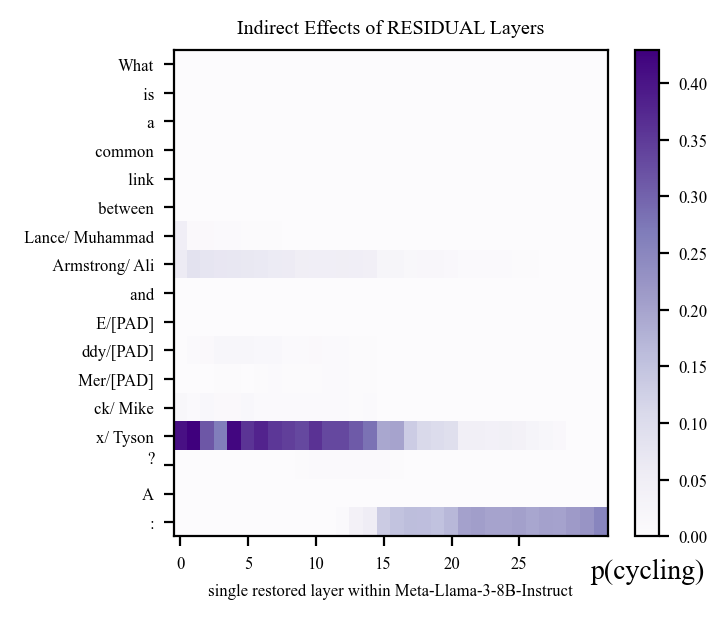

2024-08-27 18:07:22 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fac0a598a90>
2024-08-27 18:07:22 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-08-27 18:07:22 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-08-27 18:07:22 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-08-27 18:07:22 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2024-08-27 18:07:22 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-08-27 18:07:22 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2024-08-27 18:07:22 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.
2024-08-27 18:07:22 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-08-27

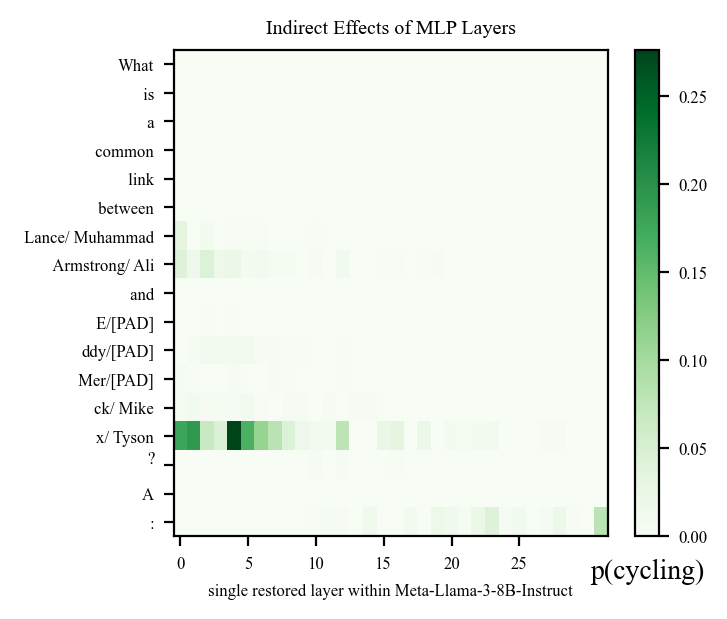

2024-08-27 18:07:22 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fac0a889290>
2024-08-27 18:07:22 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-08-27 18:07:22 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-08-27 18:07:22 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-08-27 18:07:22 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2024-08-27 18:07:22 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-08-27 18:07:22 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2024-08-27 18:07:22 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.
2024-08-27 18:07:23 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-08-27

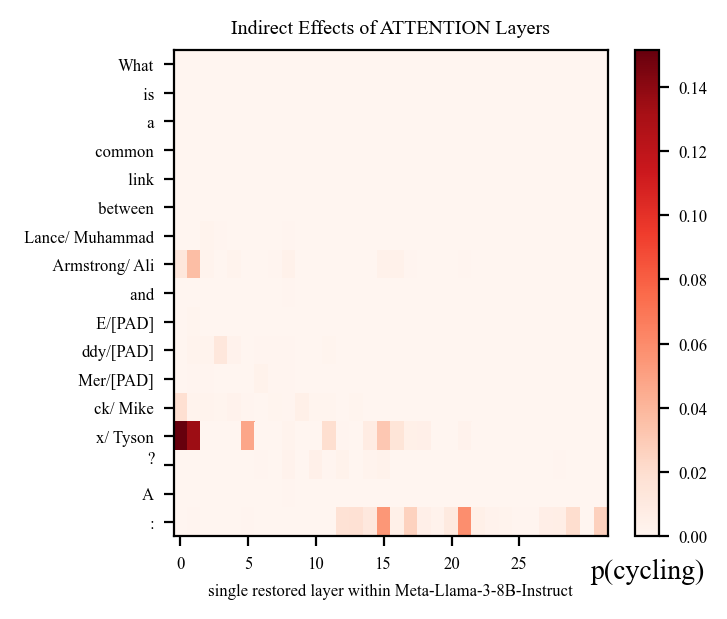

In [ ]:
from src.trace import CausalTracingResult
from src.plotting import plot_trace_heatmap

save_dir = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "Figures",
    "attrib_aie",
    relation_icq.name,
    "---".join(dataset.examples[patch_idx].entity_pair),
)
os.makedirs(save_dir, exist_ok=True)

module_to_kind = {
    mt.layer_name_format: "residual",
    mt.mlp_module_name_format: "mlp",
    mt.attn_module_name_format: "attention",
}

window_size = 1
trace_start_idx = query_start

for module_template, kind in module_to_kind.items():
    approx_effects = process_indirect_effects(module_template, window_size)
    trace_result = CausalTracingResult(
        corrupt_input_toks=[
            mt.tokenizer.decode(tok)
            for tok in clean_inputs.input_ids[0][trace_start_idx:]
        ],
        clean_input_toks=[
            mt.tokenizer.decode(tok)
            for tok in patch_inputs.input_ids[0][trace_start_idx:]
        ],
        trace_start_idx=0,
        answer=patch_ans,
        low_score=0.0,
        window=window_size,
        normalized=False,
        kind=kind,
        indirect_effects=approx_effects,
    )

    plot_trace_heatmap(
        result=trace_result,
        model_name=mt.name.split("/")[-1],
        savepdf=os.path.join(save_dir, f"{kind}.pdf"),
    )

In [ ]:
def get_layerwise_head_contributions(layer_idx, normalize=True):
    approx_effects = []
    y_labels = []
    for h_idx in range(mt.model.config.num_attention_heads):
        module_name = mt.attn_module_name_format.format(layer_idx) + f".{h_idx}"
        y_labels.append(module_name)
        head_effects = []
        for t_idx in range(query_start, clean_inputs.input_ids.shape[1]):
            head_effects.append(results[(module_name, t_idx)])
        approx_effects.append(head_effects)

    approx_effects = torch.Tensor(approx_effects)
    if normalize:
        approx_effects = (approx_effects - corrupt_rank.prob) / (
            patch_ans.prob - corrupt_rank.prob
        )

    return approx_effects, y_labels

In [ ]:
import matplotlib.pyplot as plt
from src.plotting import replace_special_tokens


def plot_head_indirect_effect(
    layer_idx, y_labels, clean_tokens, patch_tokens, approx_effects, save_pdf=None
):
    abs_max = approx_effects.abs().max().item()
    clean_tokens = replace_special_tokens(clean_tokens)
    patch_tokens = replace_special_tokens(patch_tokens)
    x_labels = []
    for clean_tok, patch_tok in zip(clean_tokens, patch_tokens):
        is_subj = clean_tok != patch_tok
        x_labels.append(f"{patch_tok} | {clean_tok}" if is_subj else f"{clean_tok}")
    with plt.rc_context(
        rc={
            "font.family": "Times New Roman",
            "font.size": 5,
        }
    ):
        plt.rcParams["figure.dpi"] = 300
        img = plt.imshow(
            approx_effects,
            cmap="RdBu",
            interpolation="nearest",
            vmin=-abs_max,
            vmax=abs_max,
        )
        plt.yticks(range(len(y_labels)), y_labels)
        plt.xticks(range(len(x_labels)), x_labels, rotation=90)
        plt.colorbar(img, orientation="vertical", aspect=50)
        plt.title(f"ATTN Layer {layer_idx} IE")

        if save_pdf is not None:
            plt.savefig(save_pdf, format="pdf", bbox_inches="tight")

        plt.show()

2024-08-27 18:08:47 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fabea7f1690>
2024-08-27 18:08:47 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2024-08-27 18:08:47 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2024-08-27 18:08:47 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


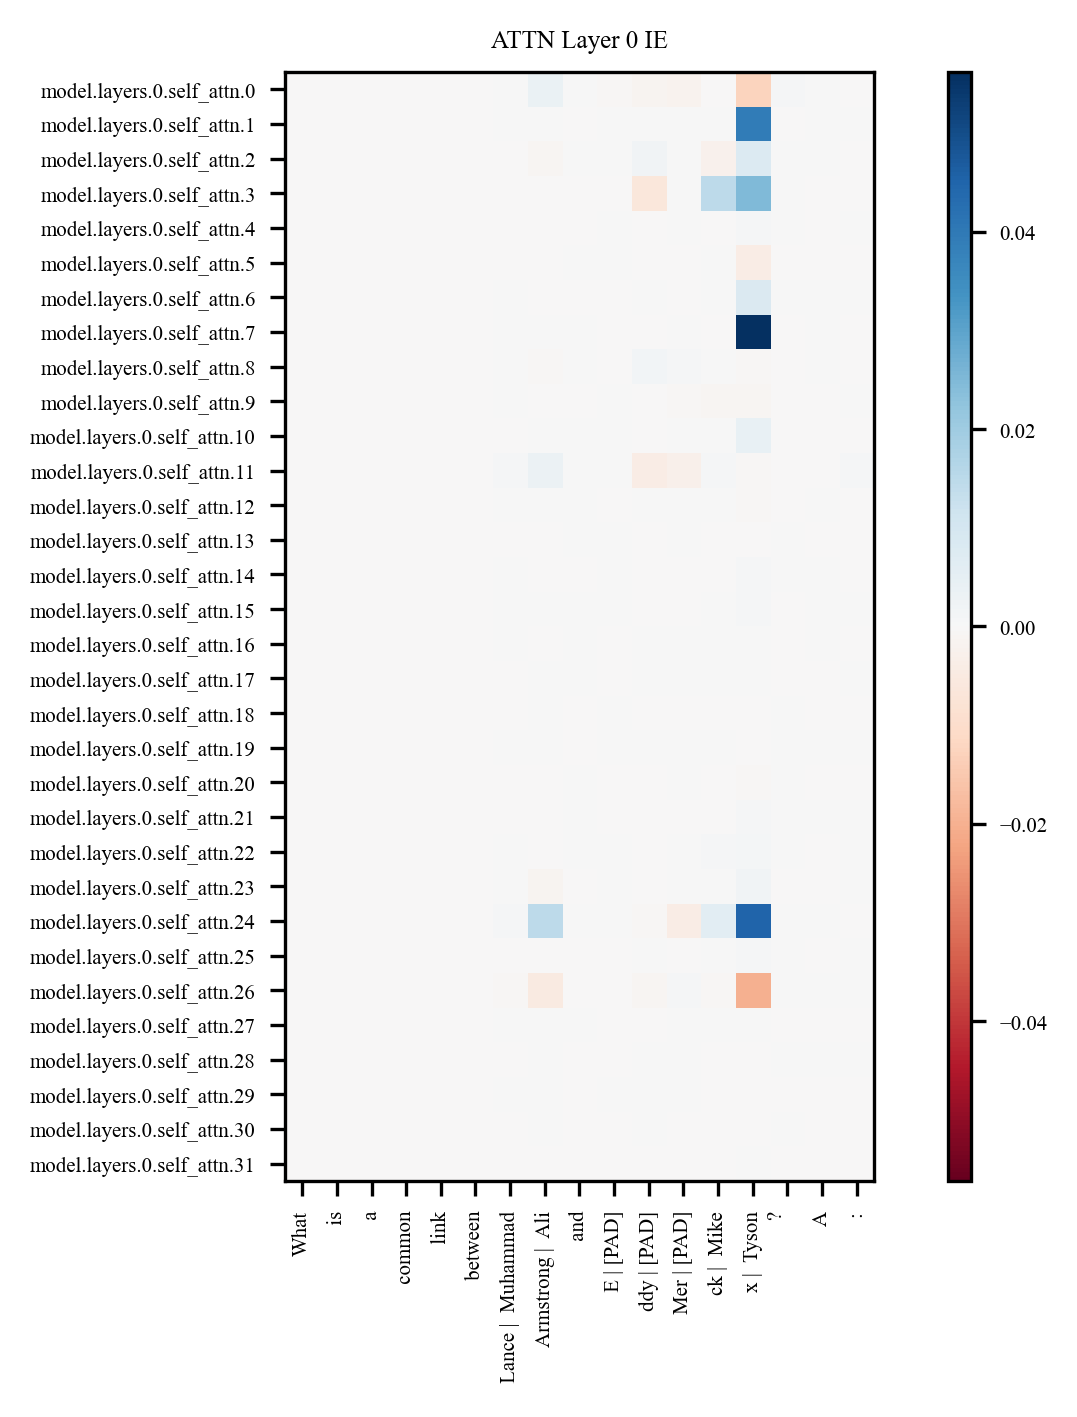

2024-08-27 18:08:48 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fabcbcab610>
2024-08-27 18:08:48 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2024-08-27 18:08:48 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2024-08-27 18:08:48 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


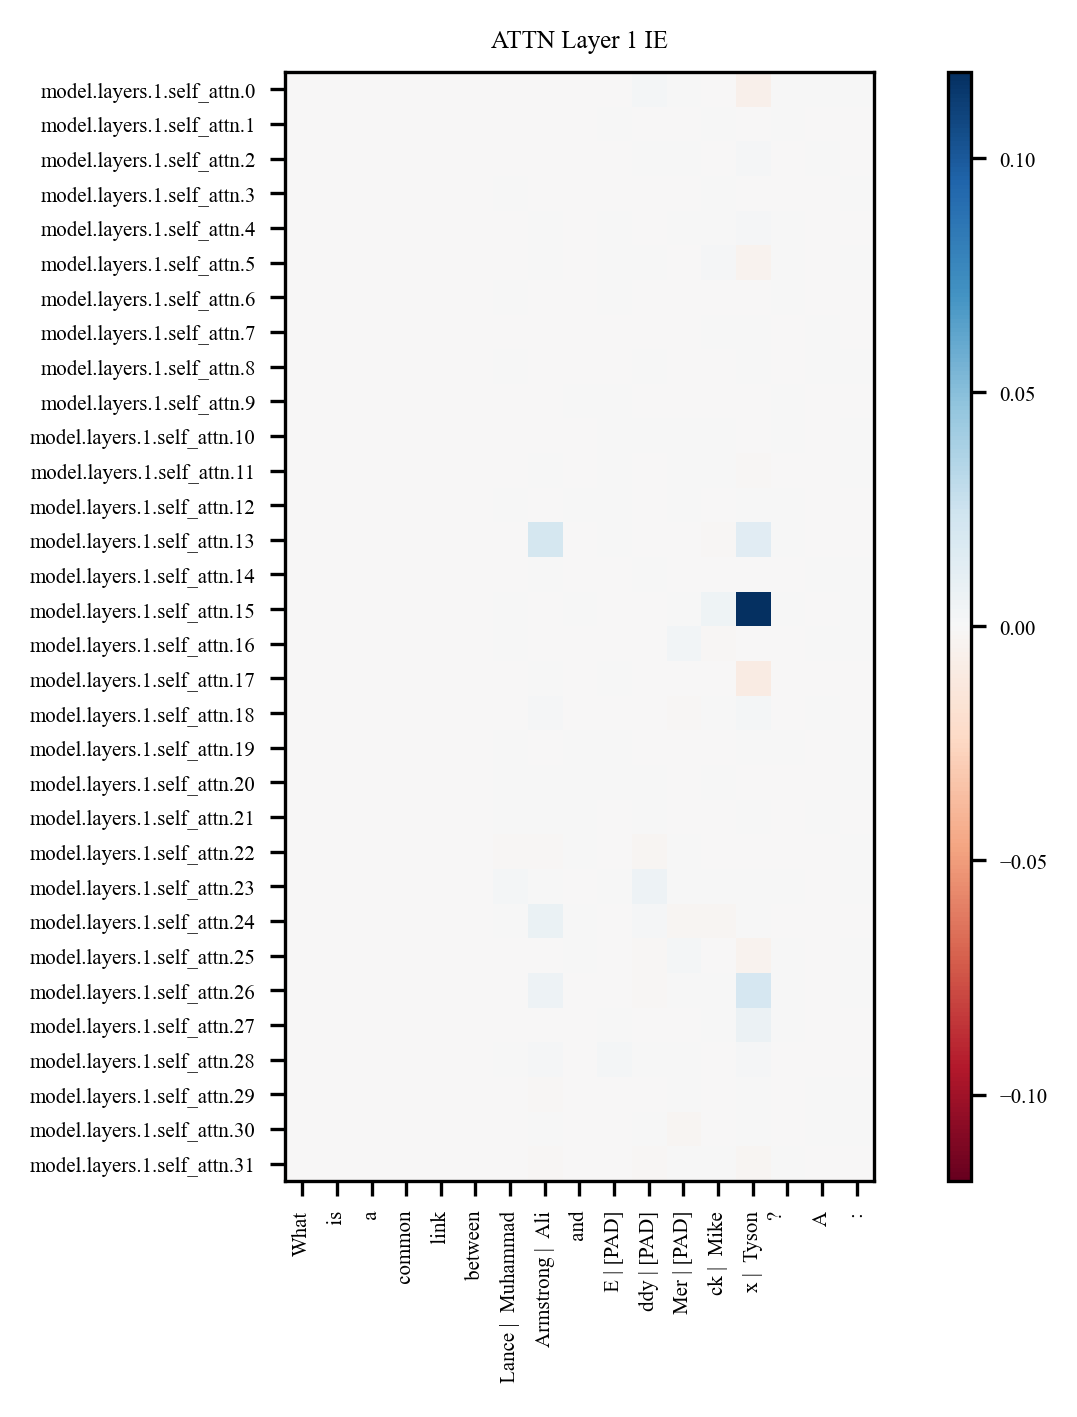

2024-08-27 18:08:48 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fadaf0f2cd0>
2024-08-27 18:08:48 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2024-08-27 18:08:48 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2024-08-27 18:08:48 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


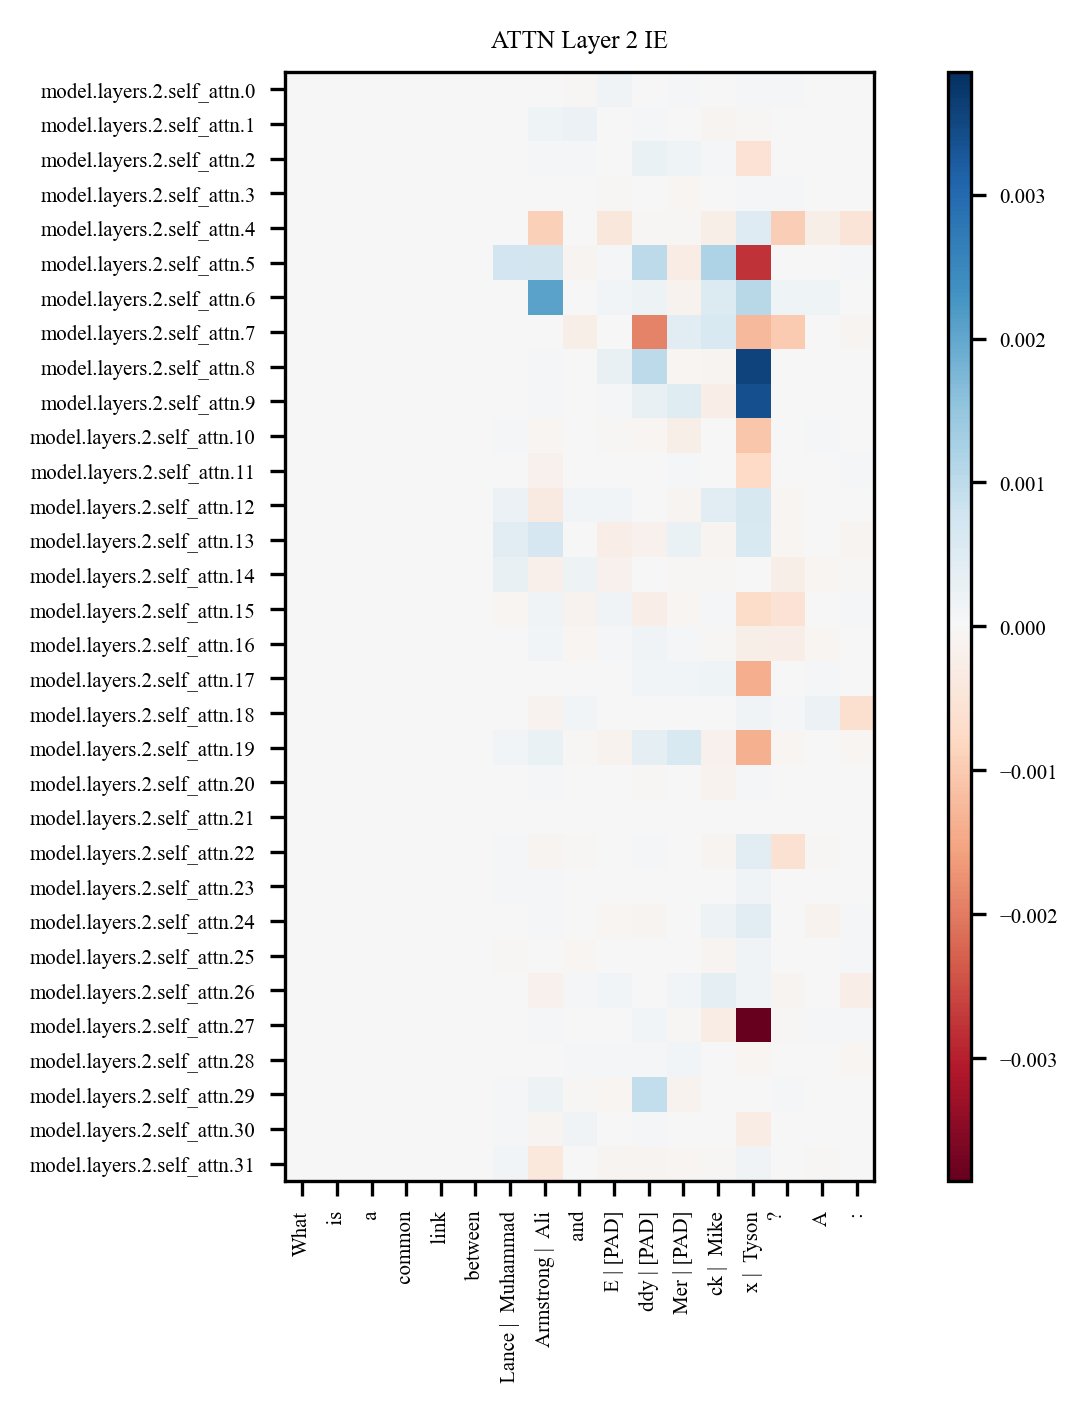

2024-08-27 18:08:49 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fa98e1b6250>
2024-08-27 18:08:49 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2024-08-27 18:08:49 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2024-08-27 18:08:49 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


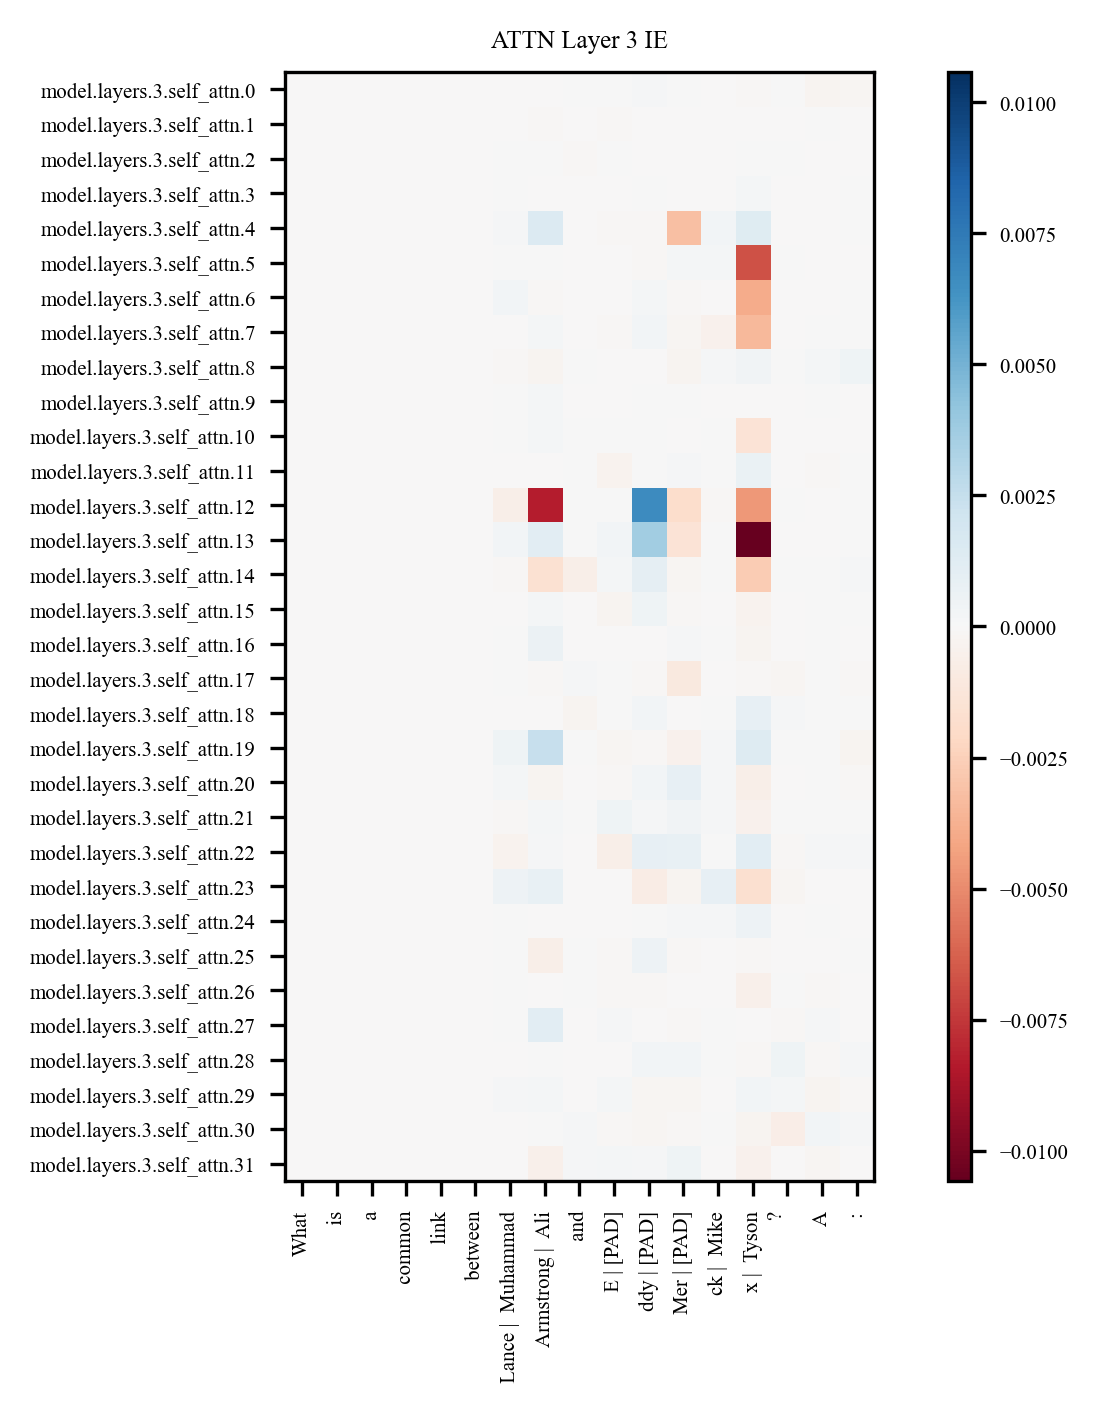

2024-08-27 18:08:49 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fae0e4e2350>
2024-08-27 18:08:49 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2024-08-27 18:08:49 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2024-08-27 18:08:49 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


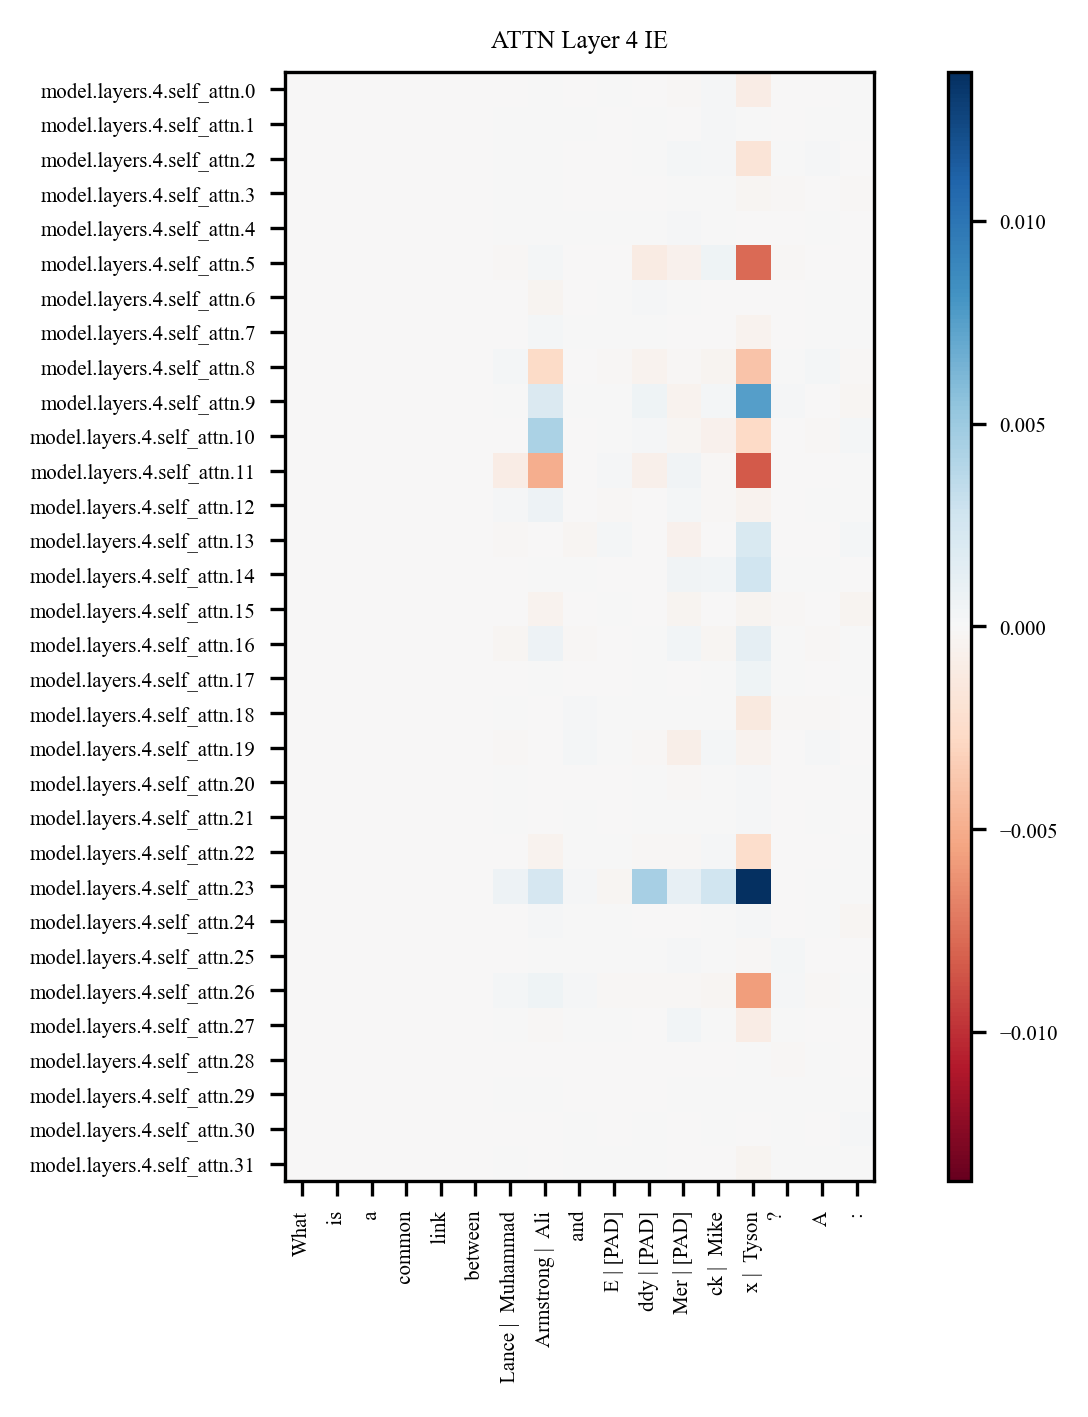

2024-08-27 18:08:50 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7faee44e3610>
2024-08-27 18:08:50 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2024-08-27 18:08:50 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2024-08-27 18:08:50 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


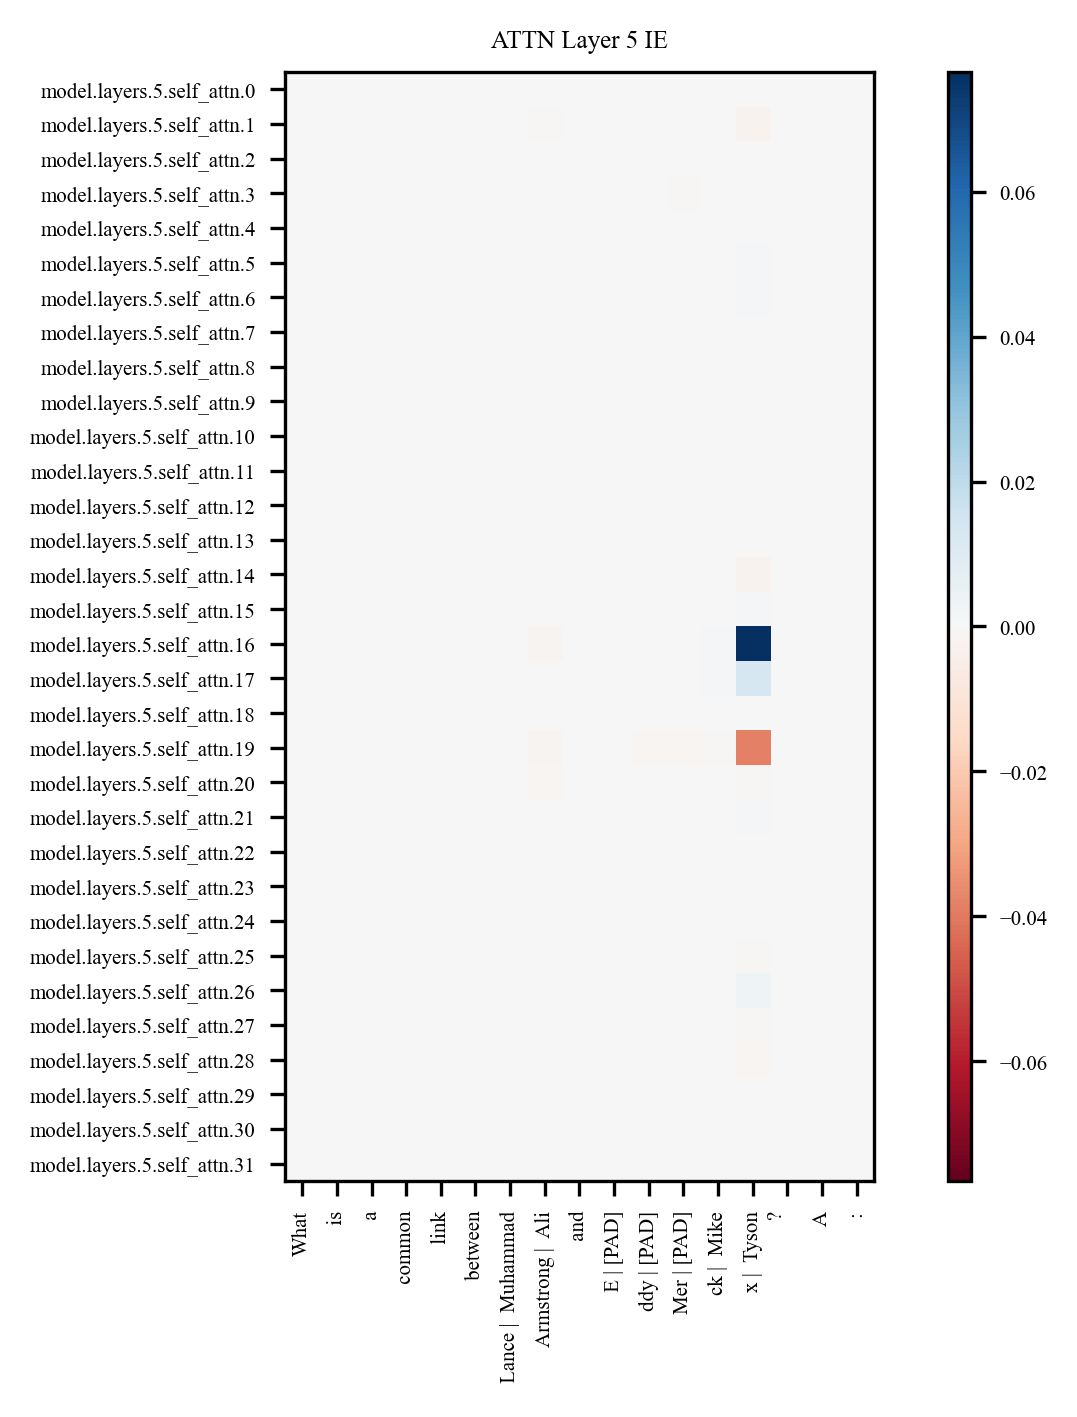

2024-08-27 18:08:50 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7faf1351ab90>
2024-08-27 18:08:50 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2024-08-27 18:08:50 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2024-08-27 18:08:50 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


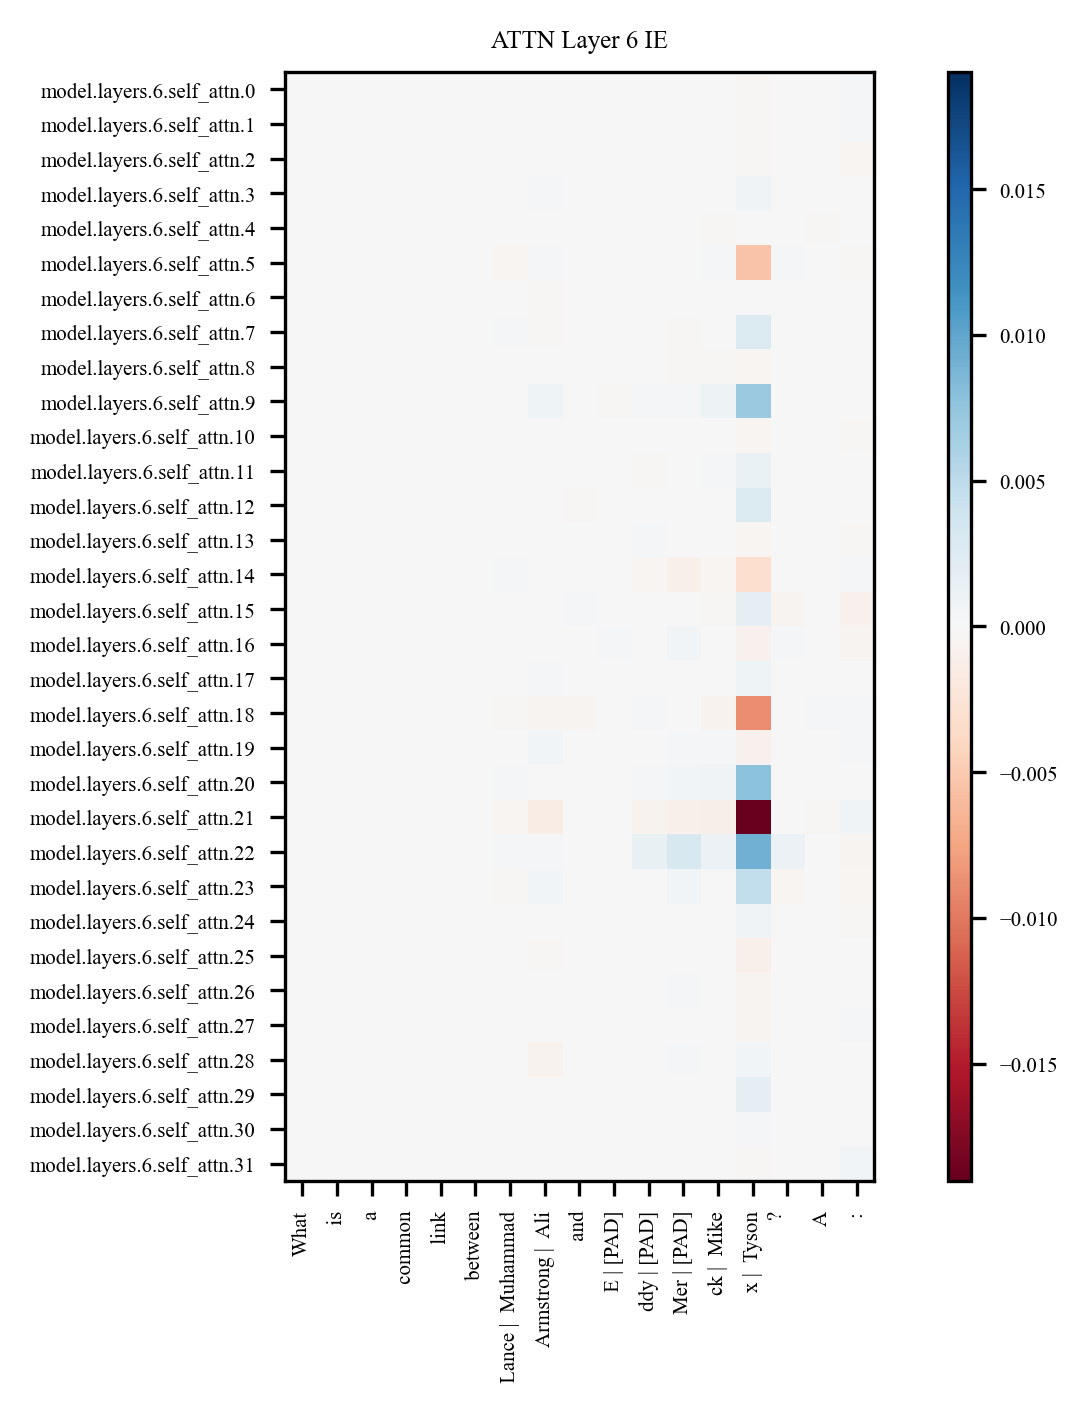

2024-08-27 18:08:51 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fad2e553f10>
2024-08-27 18:08:51 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2024-08-27 18:08:51 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2024-08-27 18:08:51 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


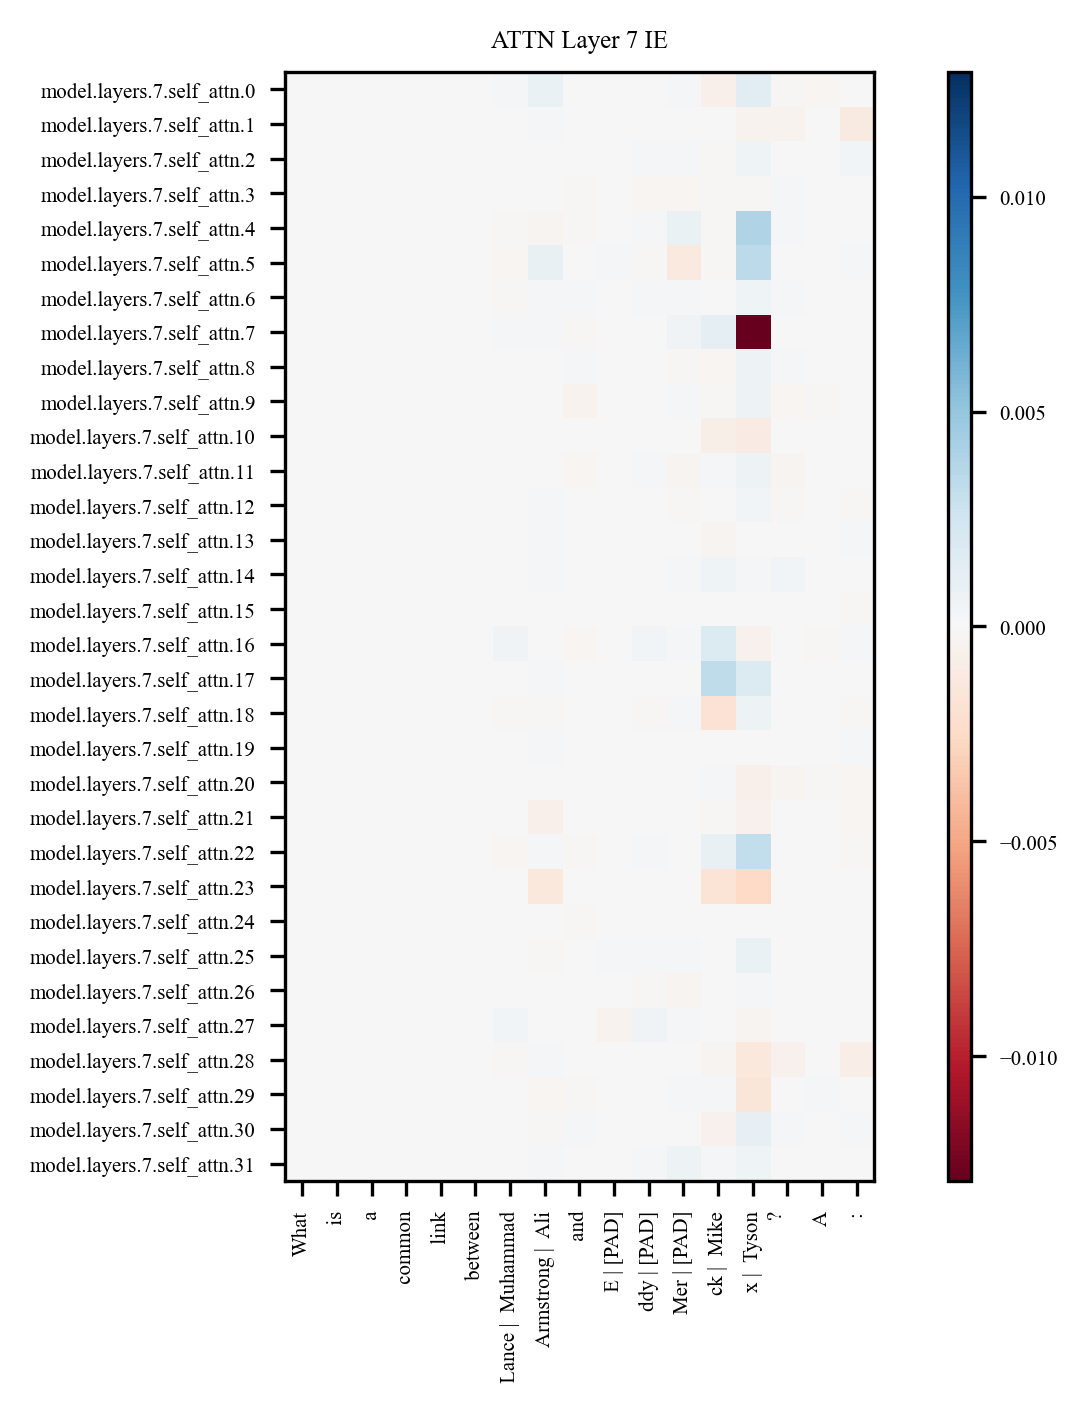

2024-08-27 18:08:51 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fadeed24690>
2024-08-27 18:08:51 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2024-08-27 18:08:51 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2024-08-27 18:08:51 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


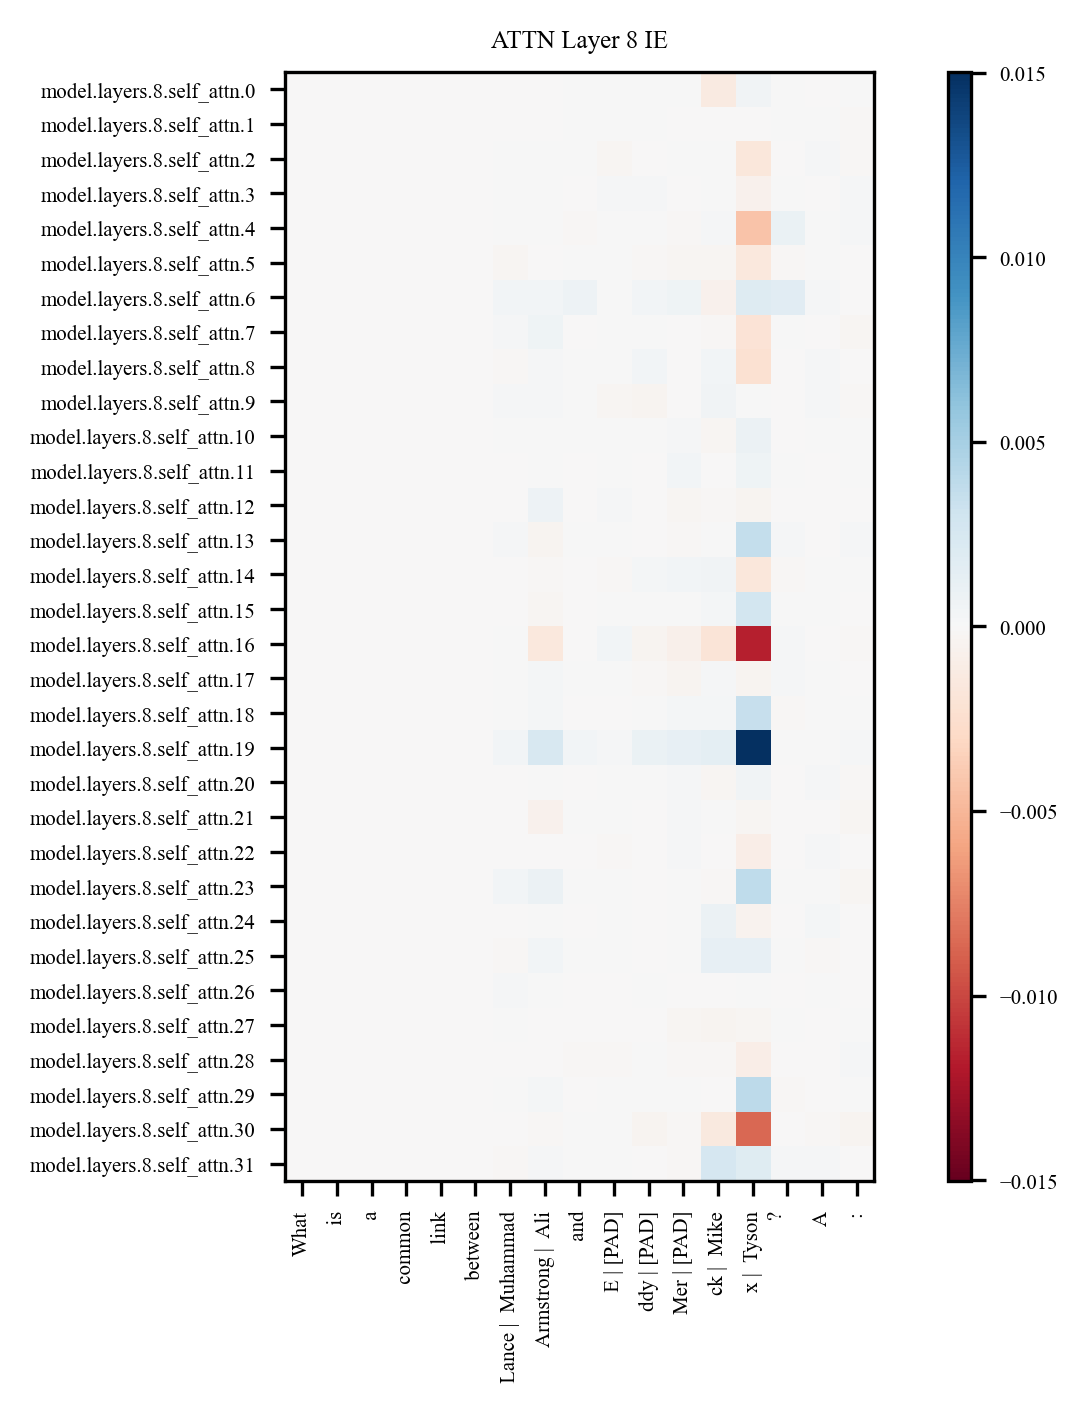

2024-08-27 18:08:52 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fad4f659010>
2024-08-27 18:08:52 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2024-08-27 18:08:52 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2024-08-27 18:08:52 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


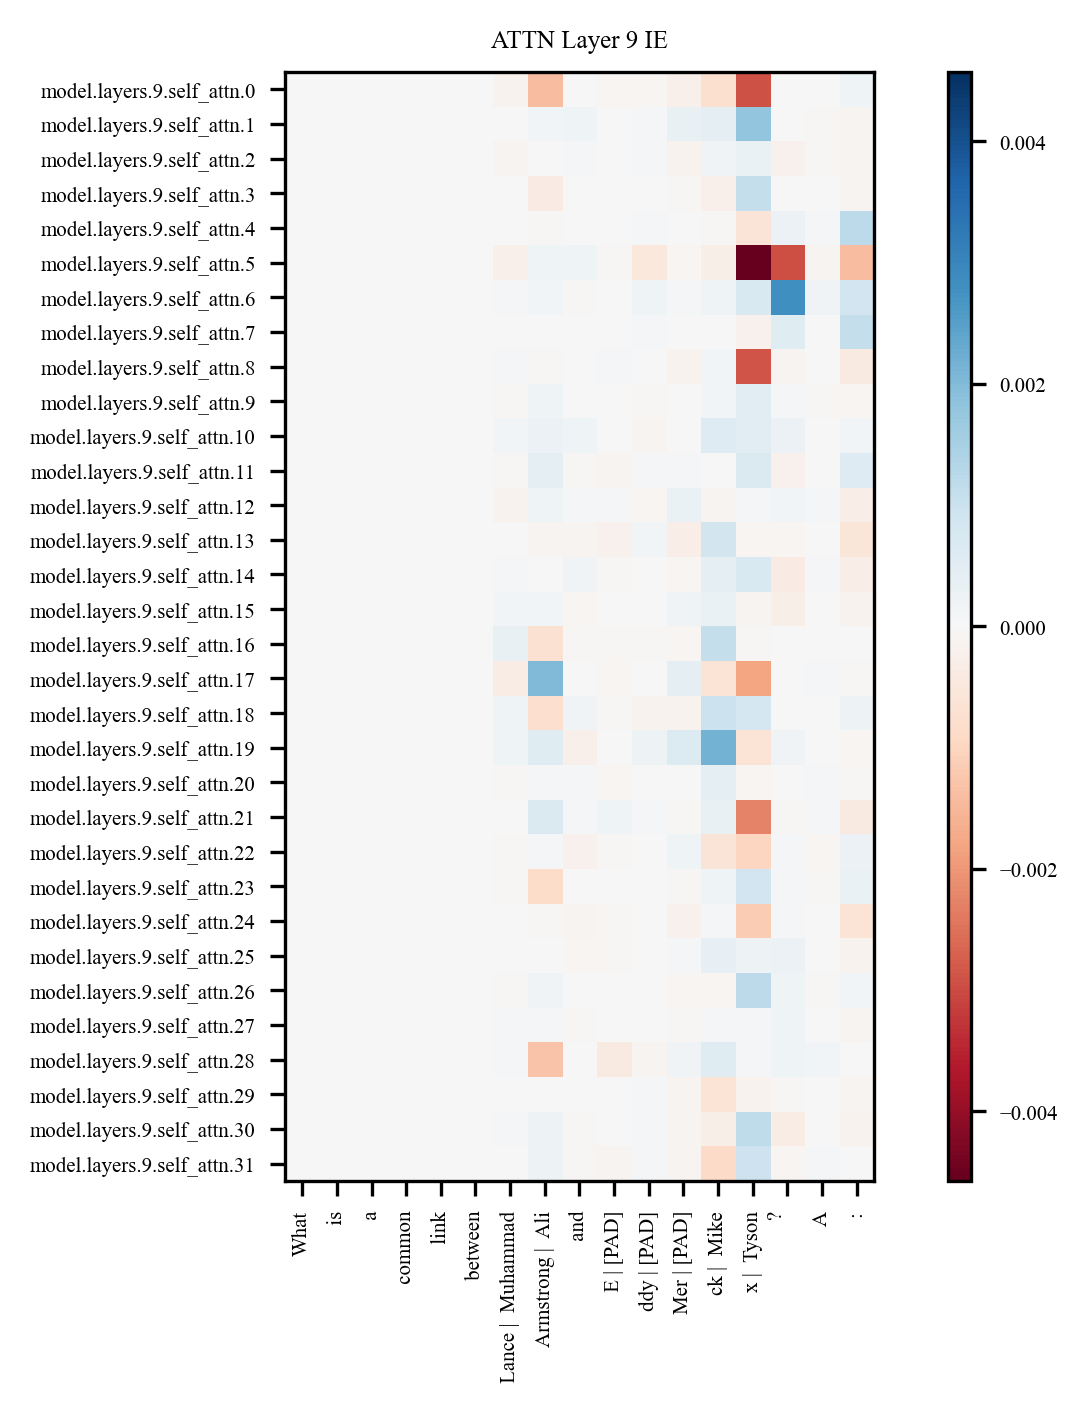

2024-08-27 18:08:52 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fadeefa2bd0>
2024-08-27 18:08:52 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2024-08-27 18:08:53 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2024-08-27 18:08:53 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


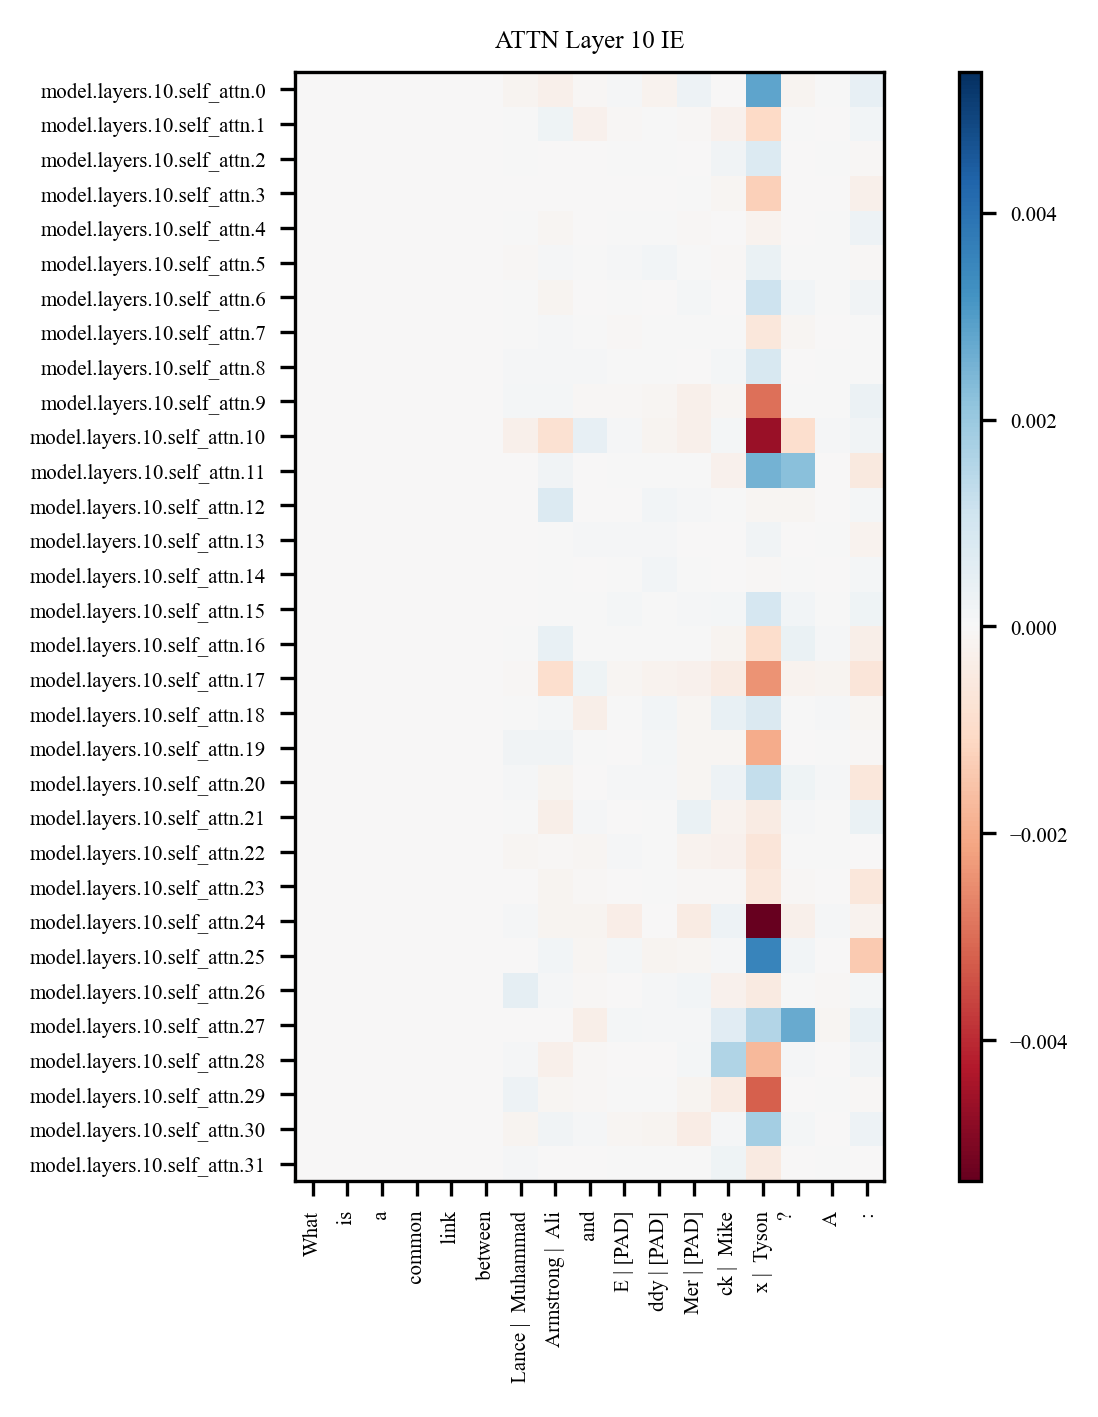

2024-08-27 18:08:53 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7facea166190>
2024-08-27 18:08:53 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2024-08-27 18:08:53 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2024-08-27 18:08:53 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


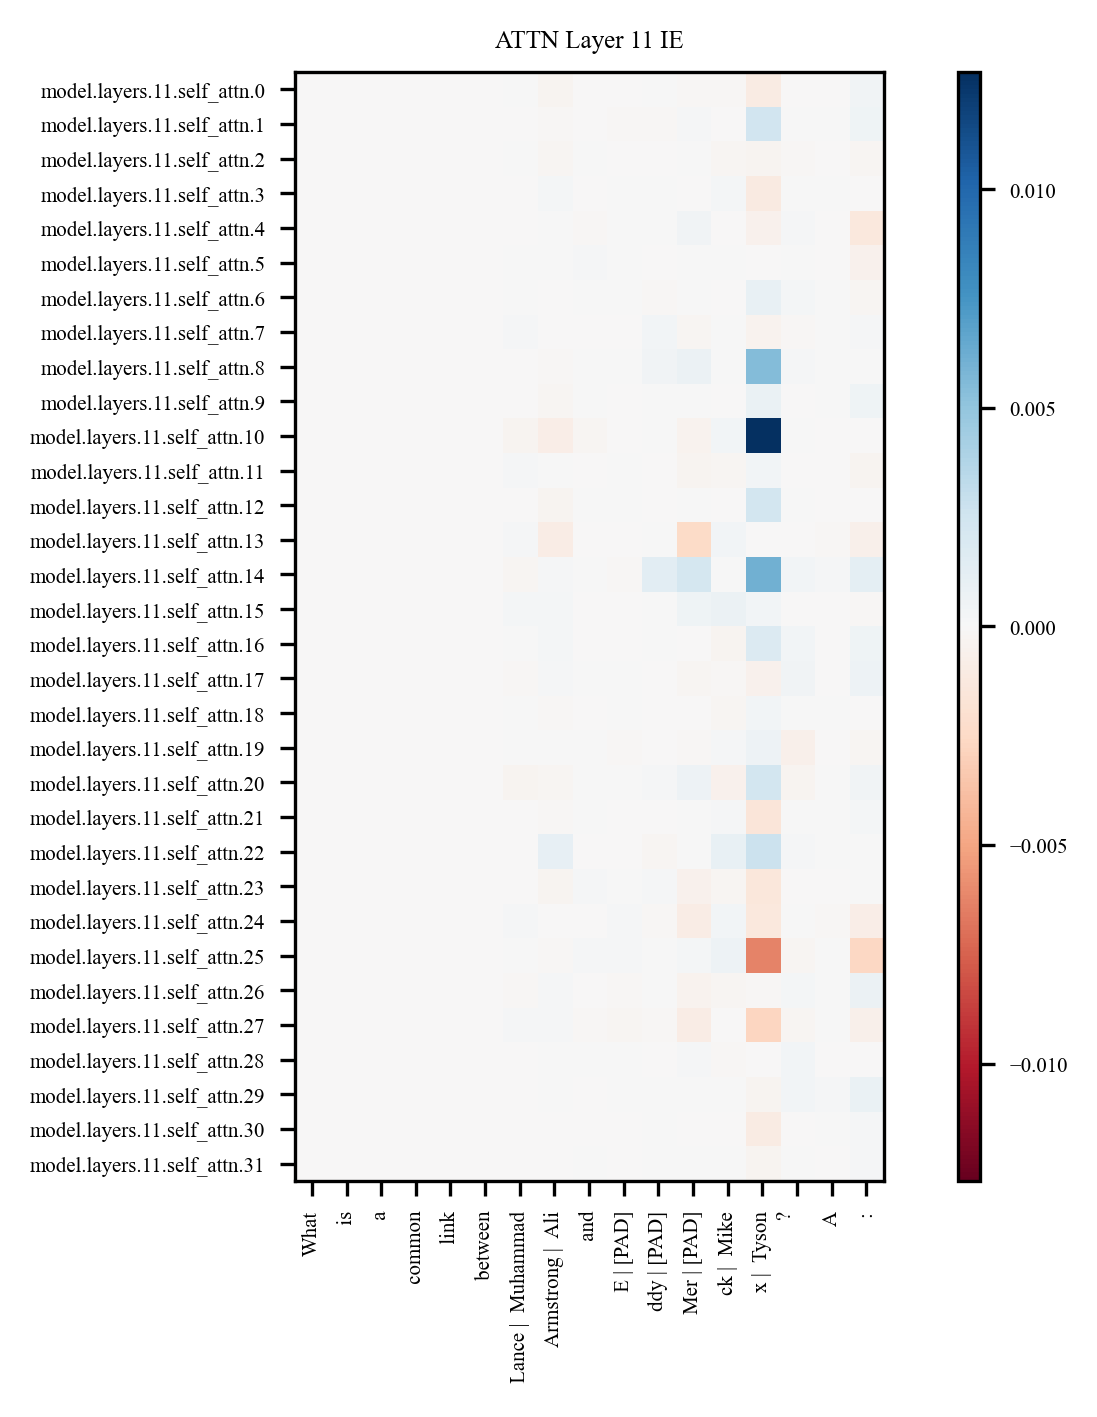

2024-08-27 18:08:53 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fae805b8550>
2024-08-27 18:08:54 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2024-08-27 18:08:54 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2024-08-27 18:08:54 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


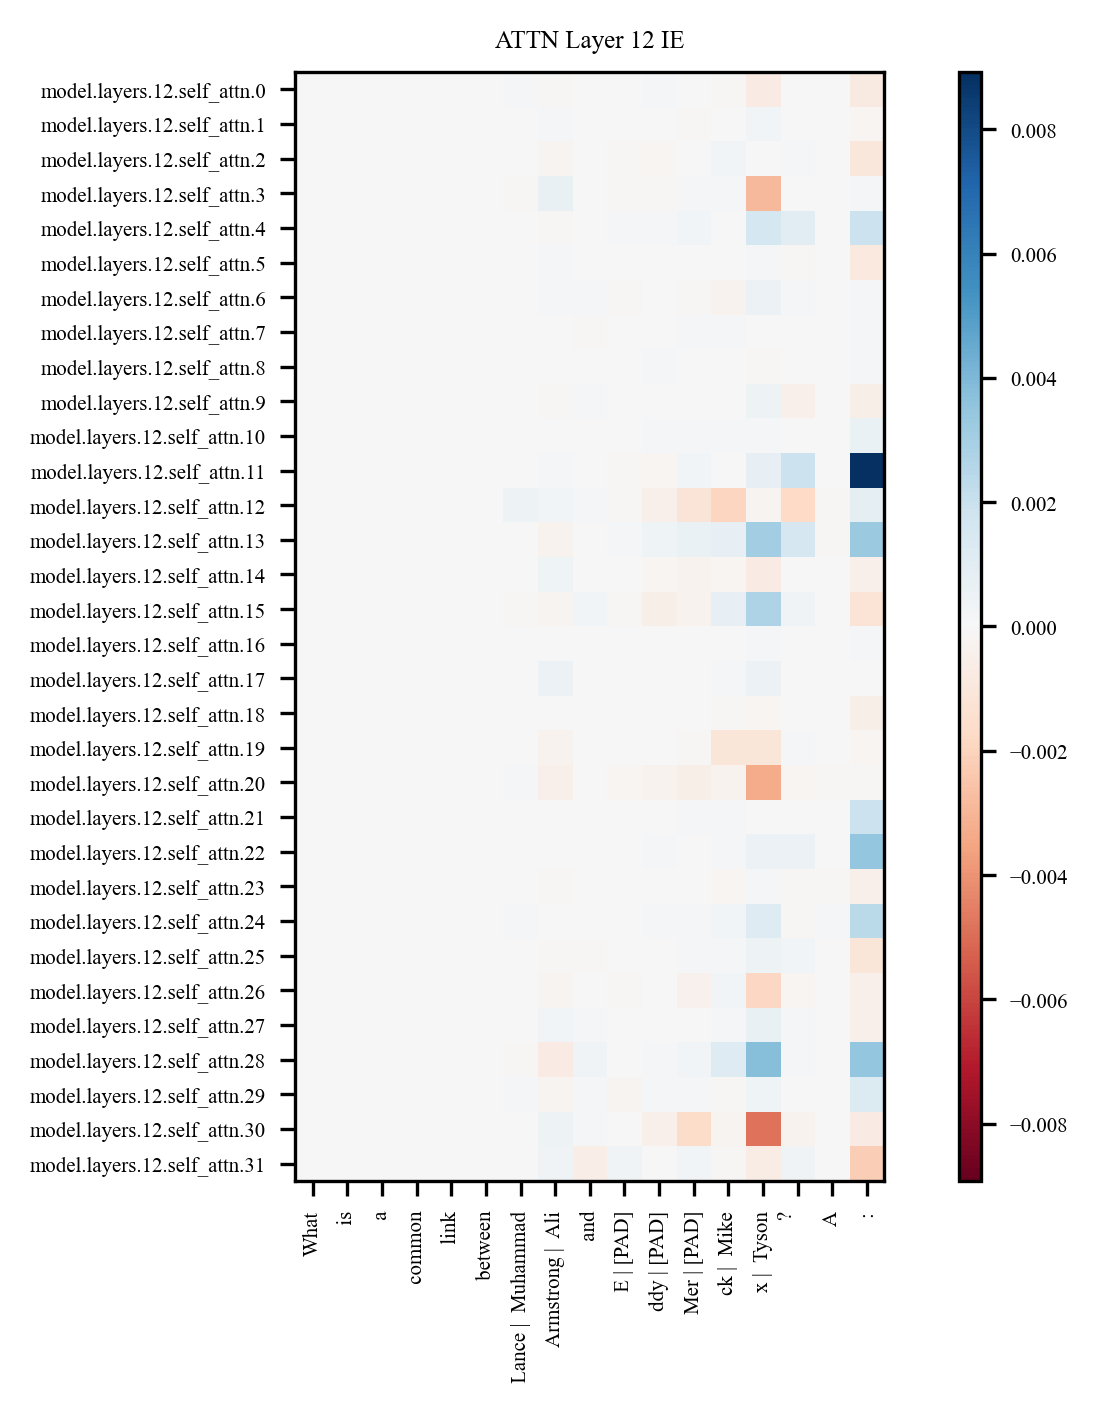

2024-08-27 18:08:54 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fadee437f90>
2024-08-27 18:08:54 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2024-08-27 18:08:54 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2024-08-27 18:08:54 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


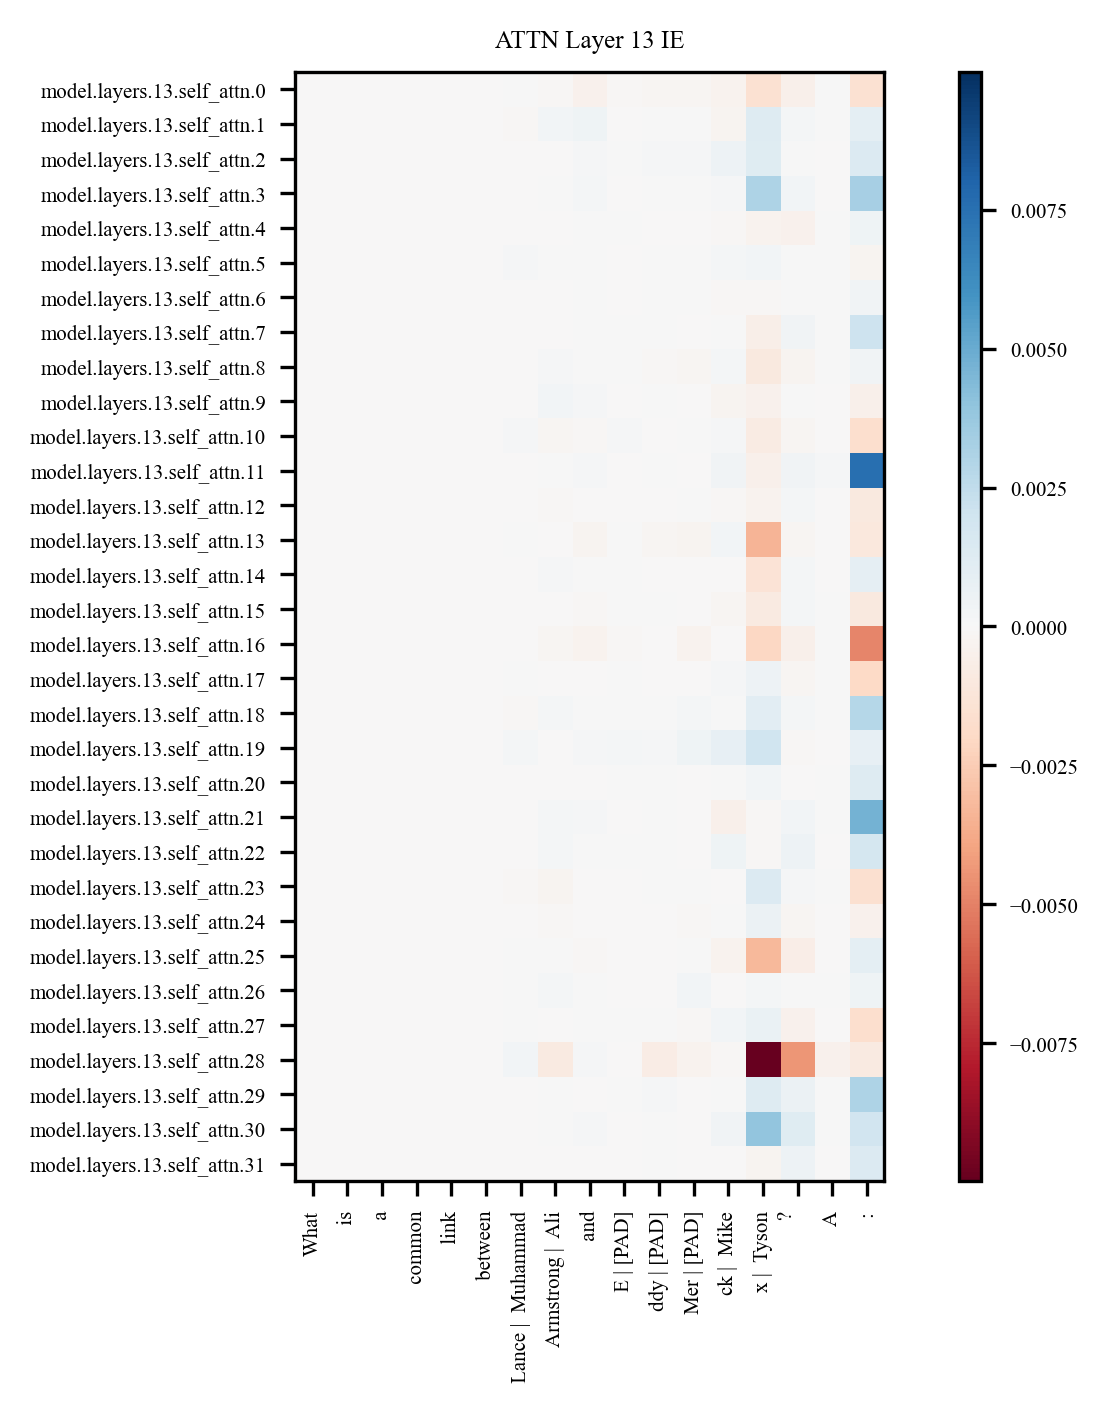

2024-08-27 18:08:54 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fadcf92ee10>
2024-08-27 18:08:55 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2024-08-27 18:08:55 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2024-08-27 18:08:55 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


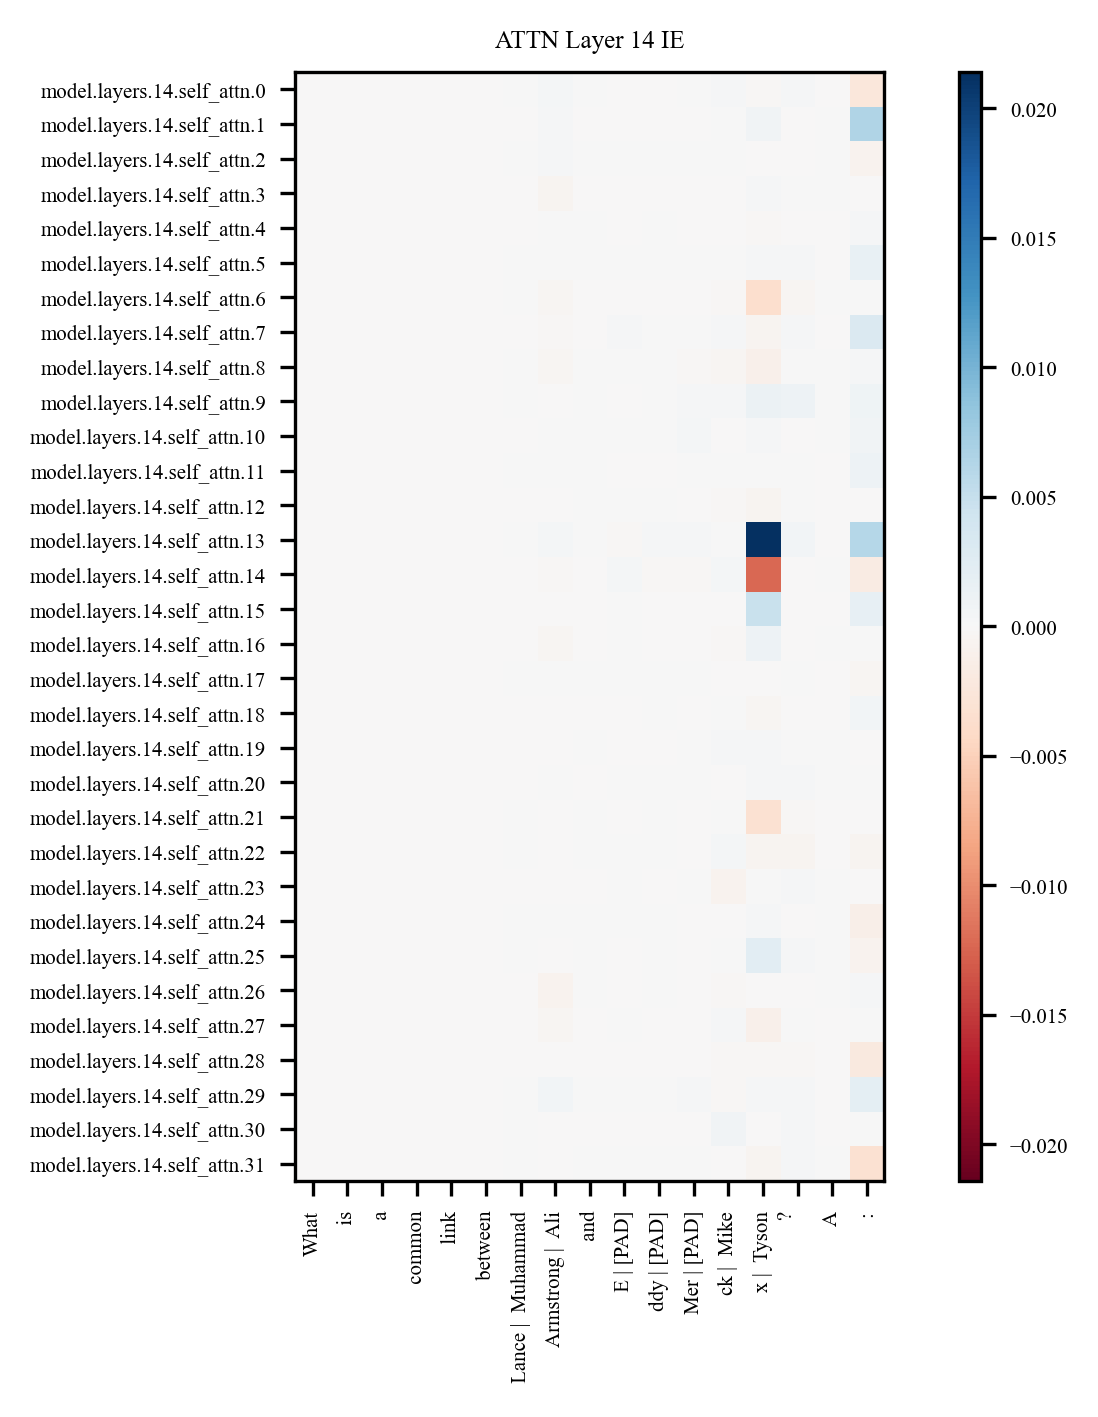

2024-08-27 18:08:55 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fadcf6889d0>
2024-08-27 18:08:55 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2024-08-27 18:08:55 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2024-08-27 18:08:55 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


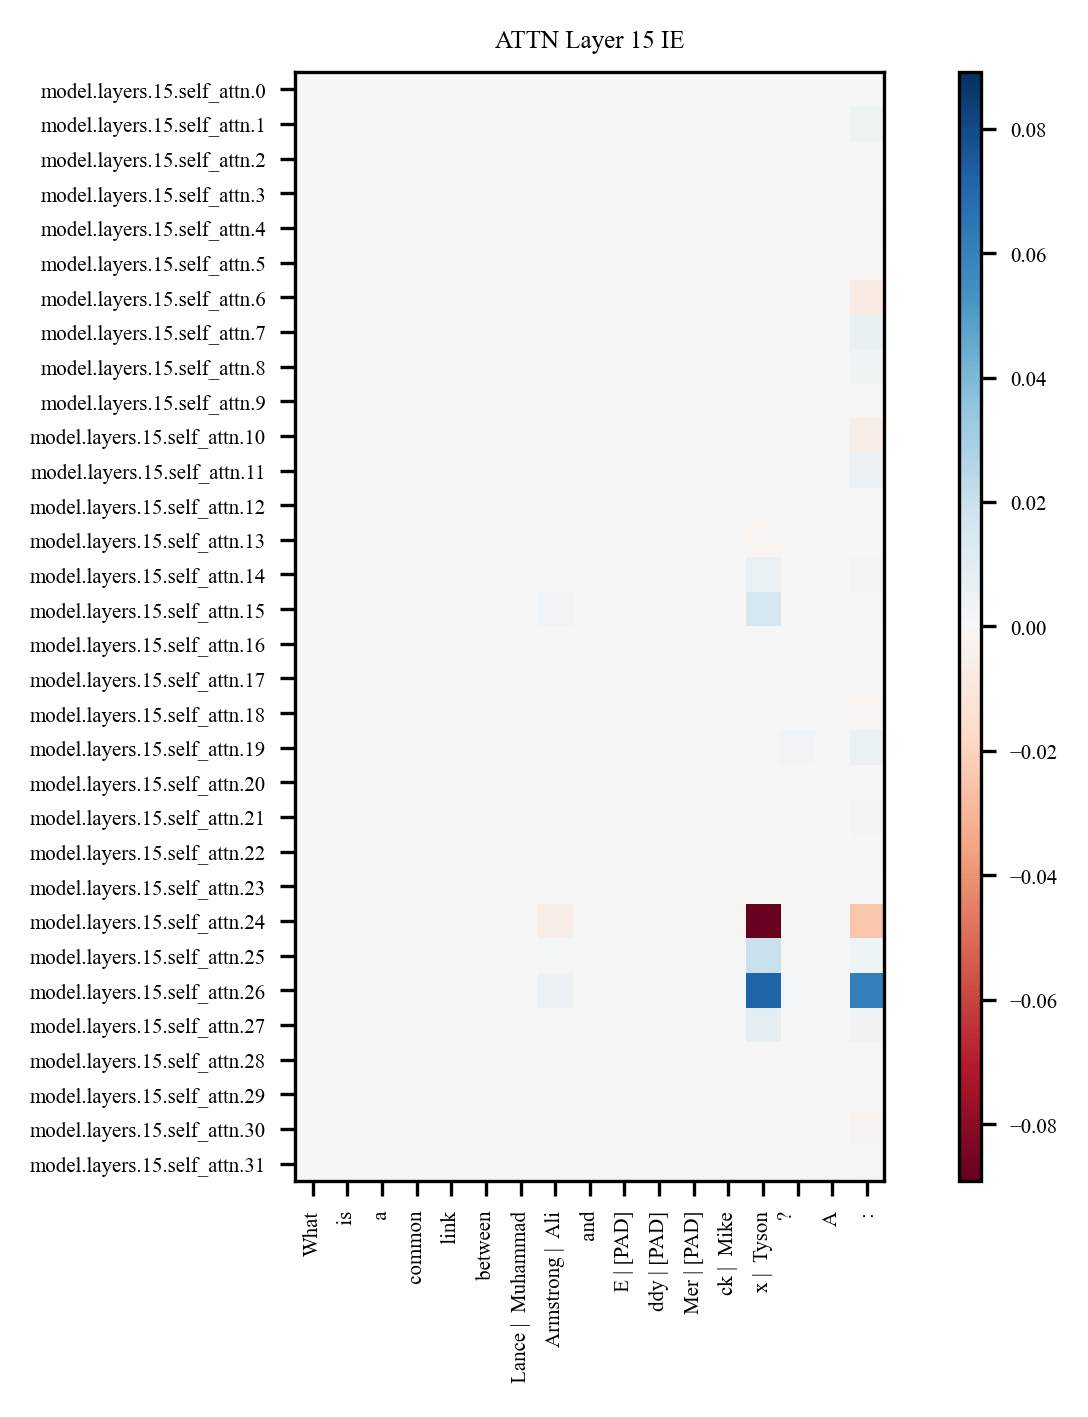

2024-08-27 18:08:56 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7faa055b8d50>
2024-08-27 18:08:56 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2024-08-27 18:08:56 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2024-08-27 18:08:56 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


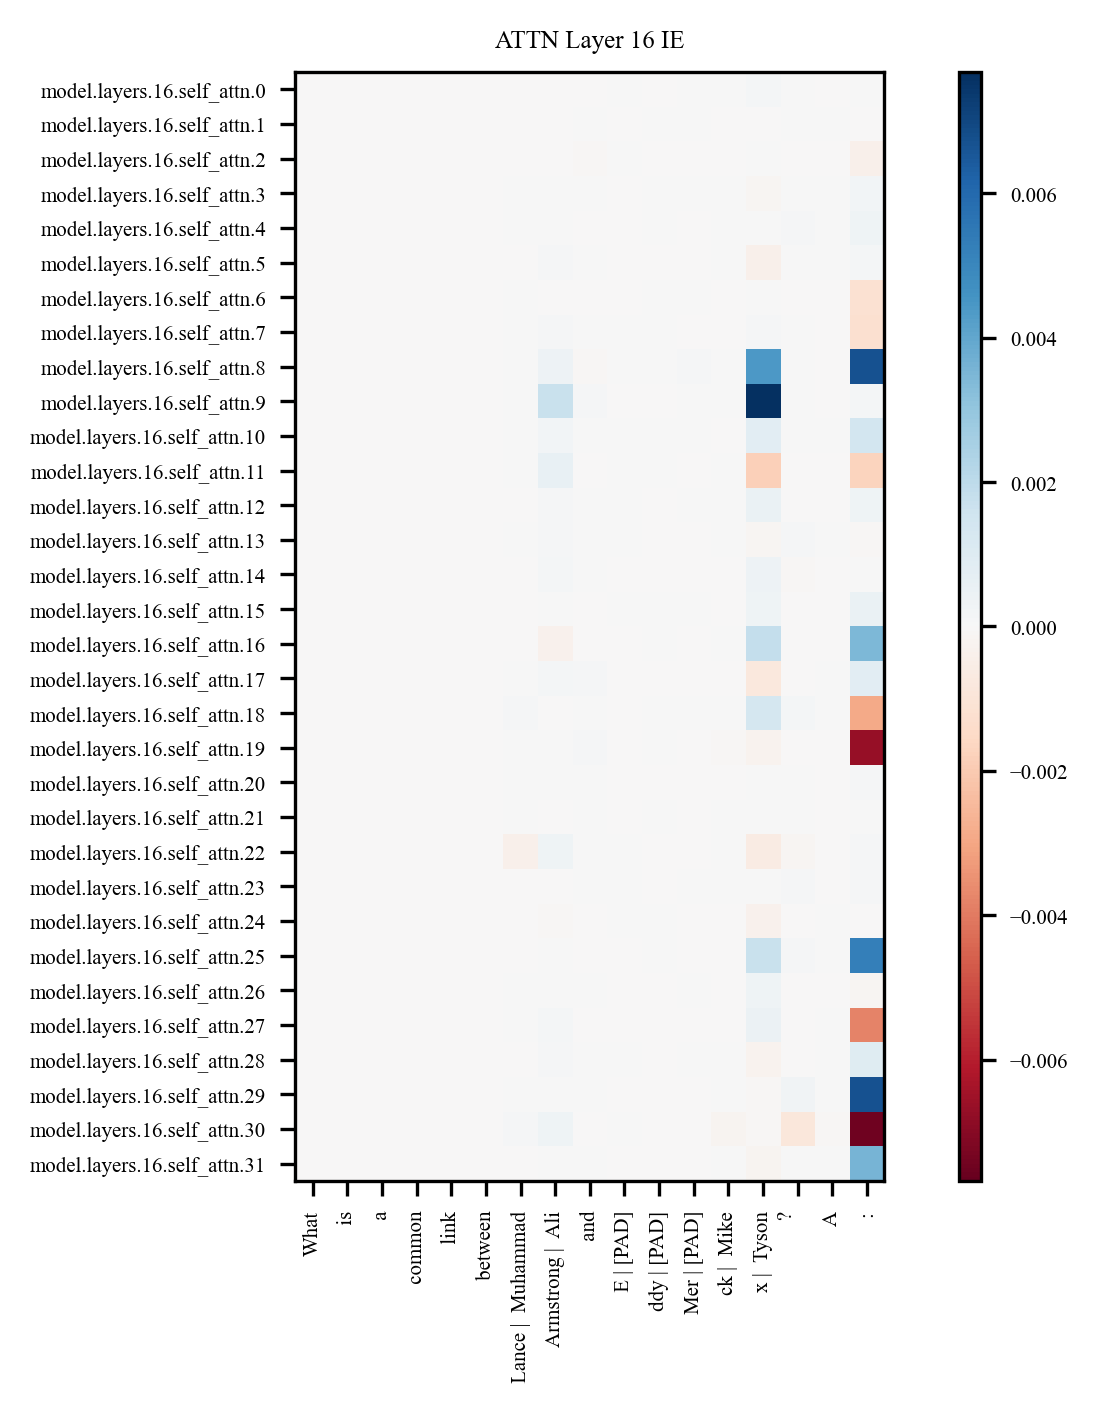

2024-08-27 18:08:56 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7faceb9d2b90>
2024-08-27 18:08:56 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2024-08-27 18:08:56 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2024-08-27 18:08:56 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


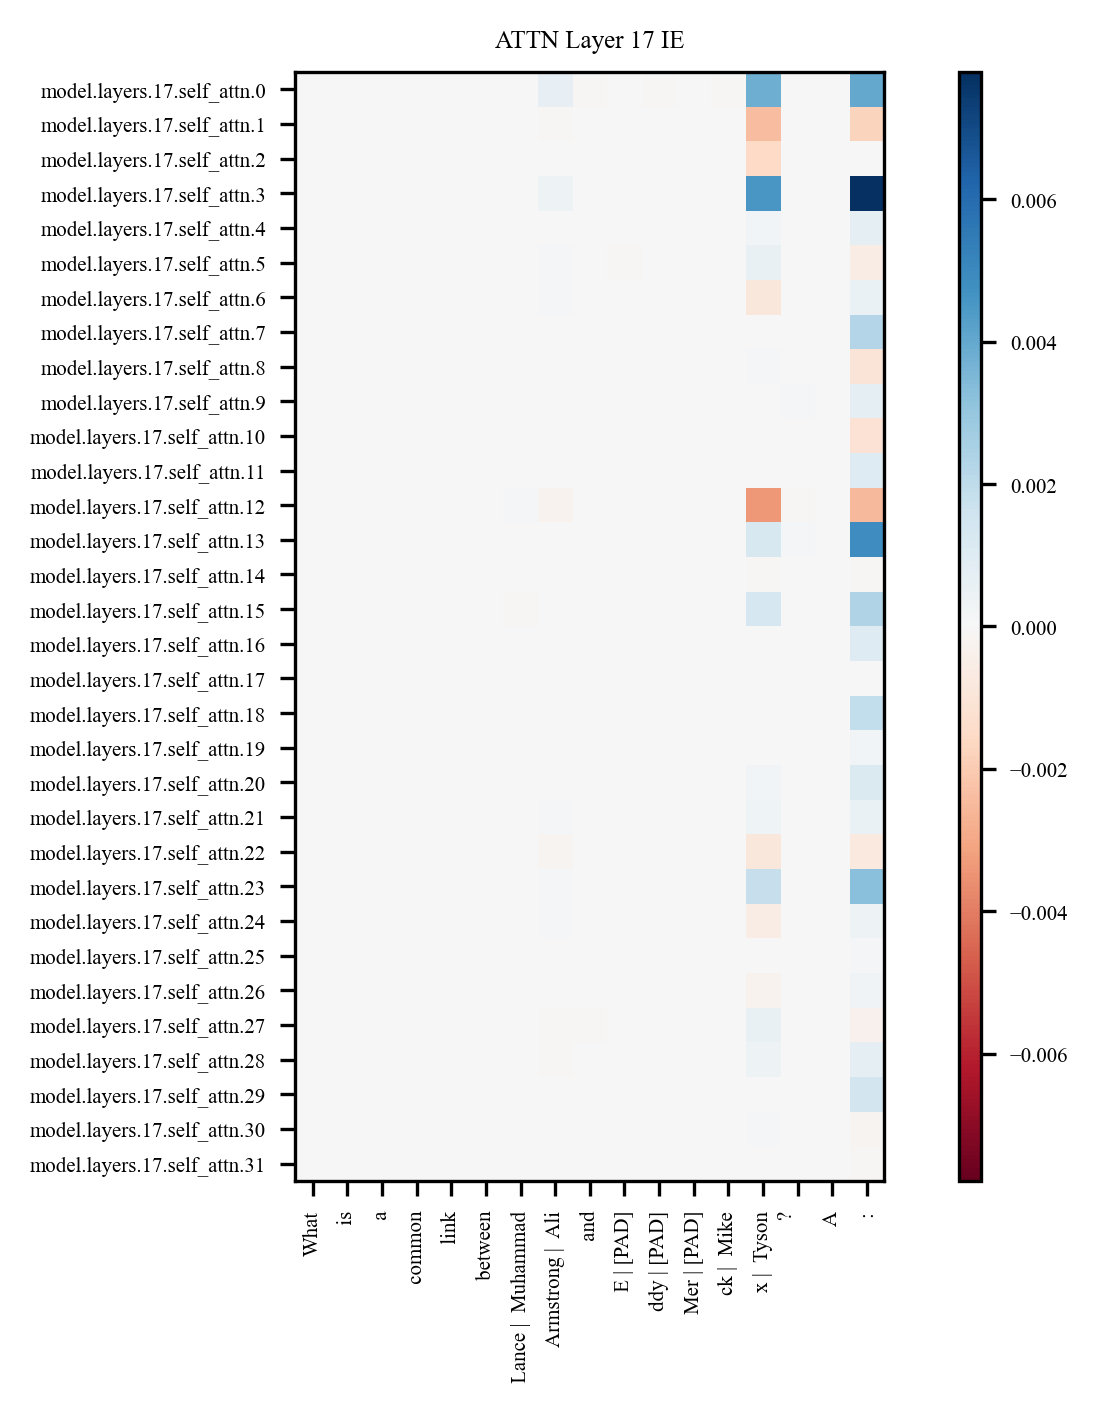

2024-08-27 18:08:57 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fad2e41dfd0>
2024-08-27 18:08:57 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2024-08-27 18:08:57 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2024-08-27 18:08:57 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


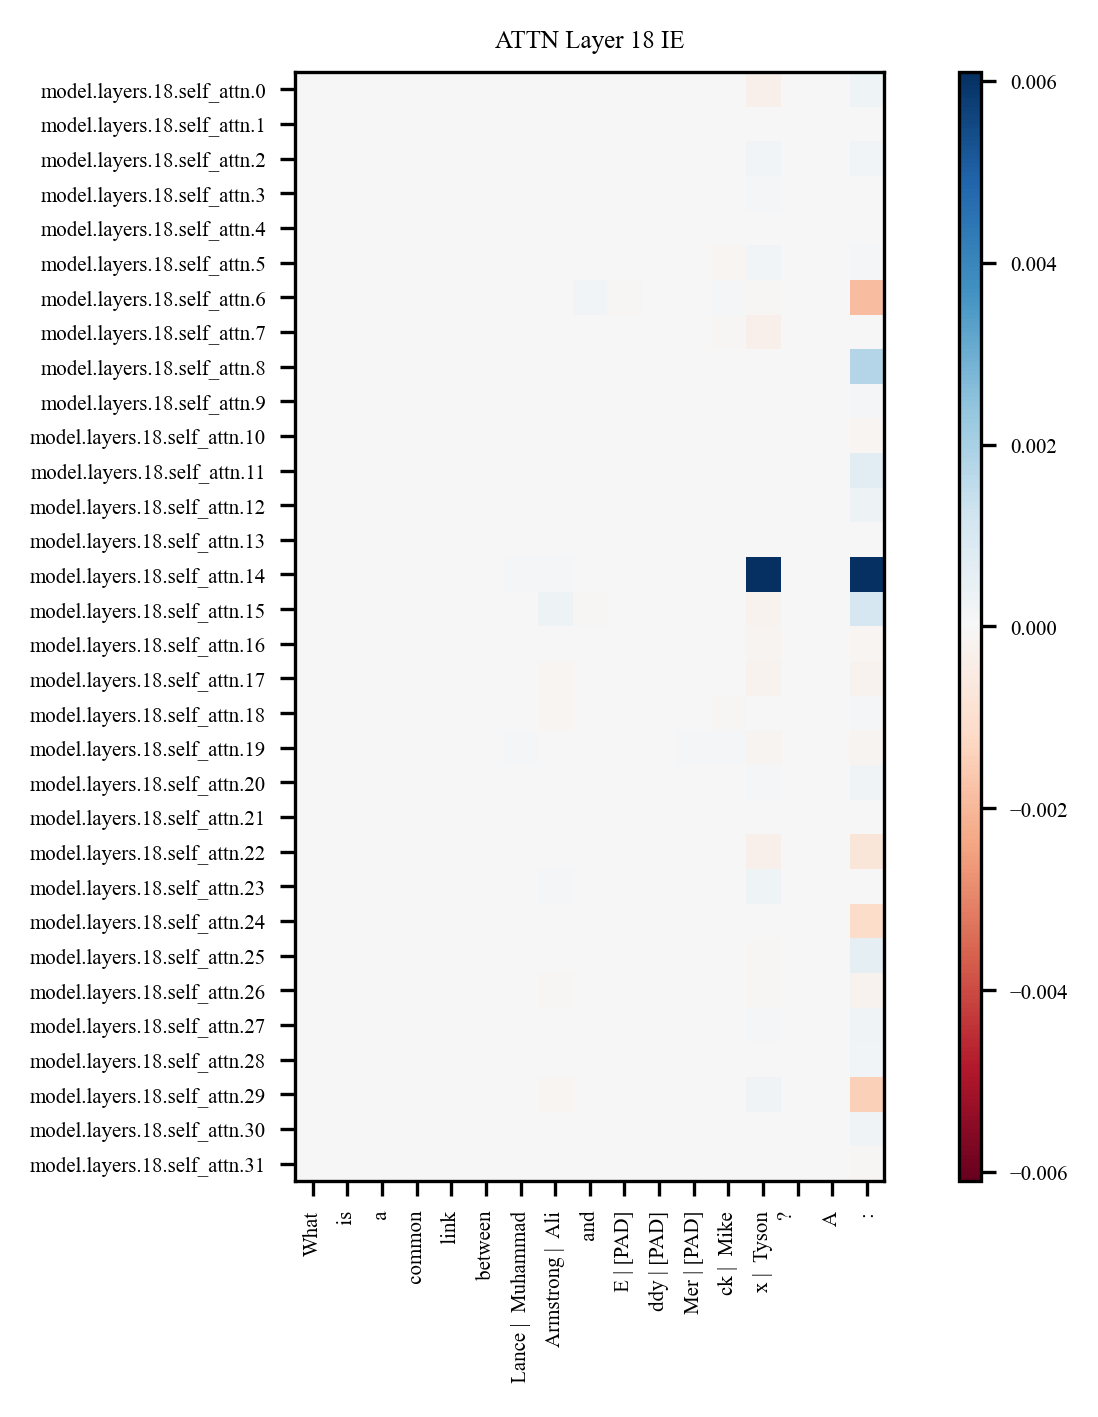

2024-08-27 18:08:57 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fad8fa12350>
2024-08-27 18:08:57 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2024-08-27 18:08:57 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2024-08-27 18:08:57 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


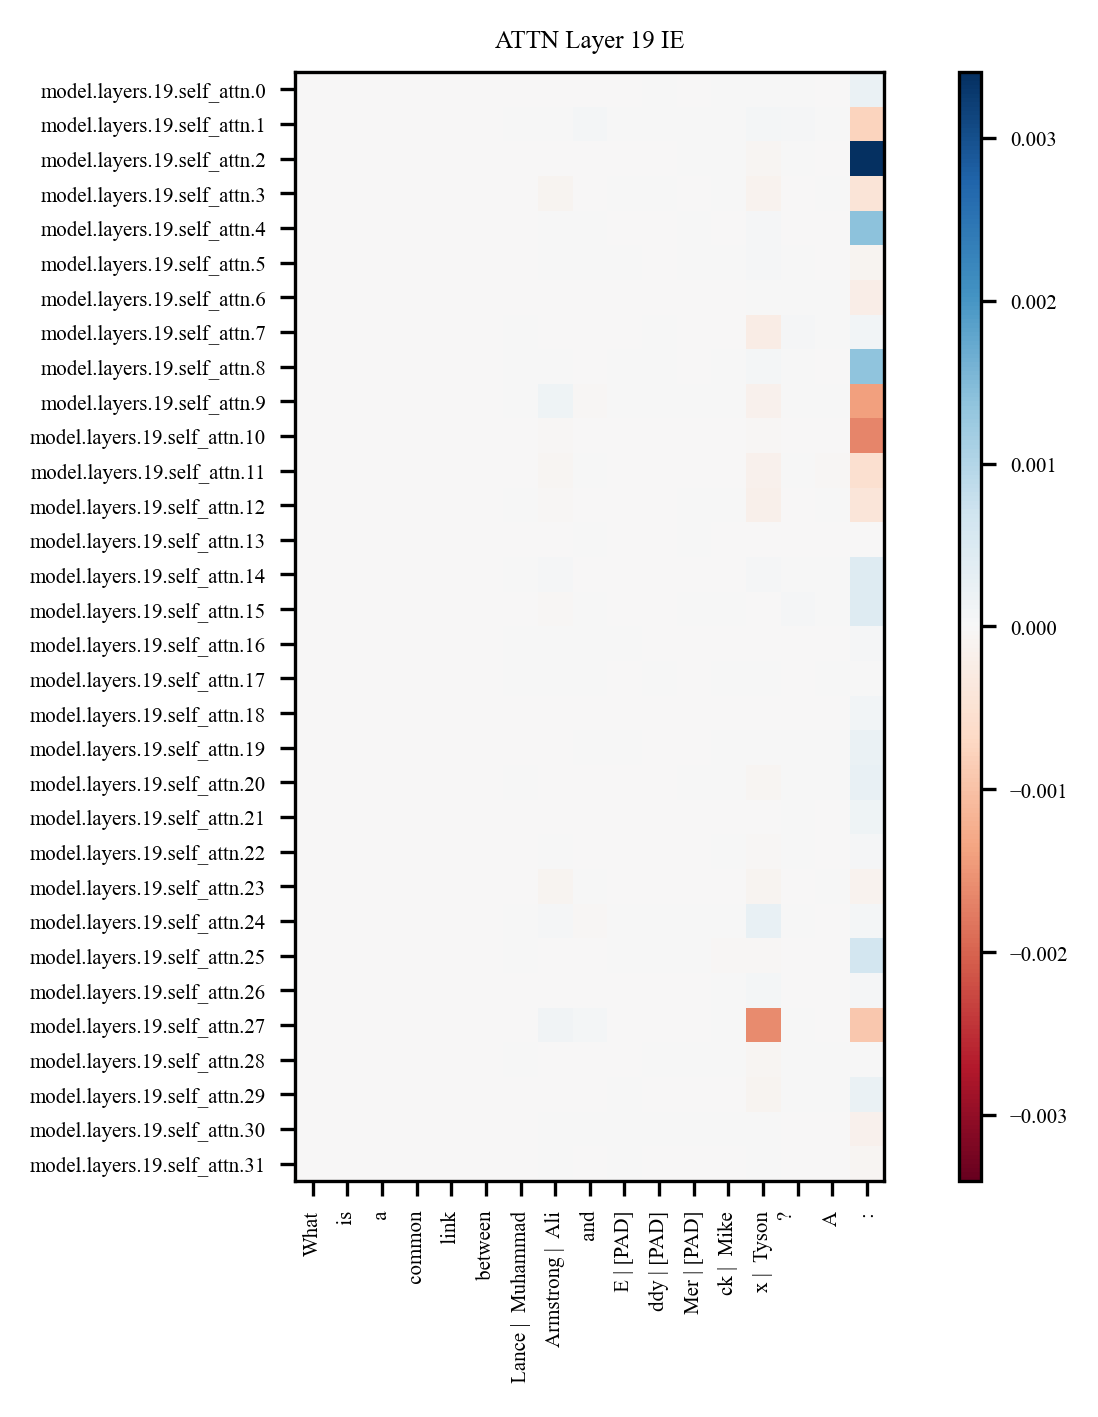

2024-08-27 18:08:58 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fad8ef5c890>
2024-08-27 18:08:58 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2024-08-27 18:08:58 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2024-08-27 18:08:58 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


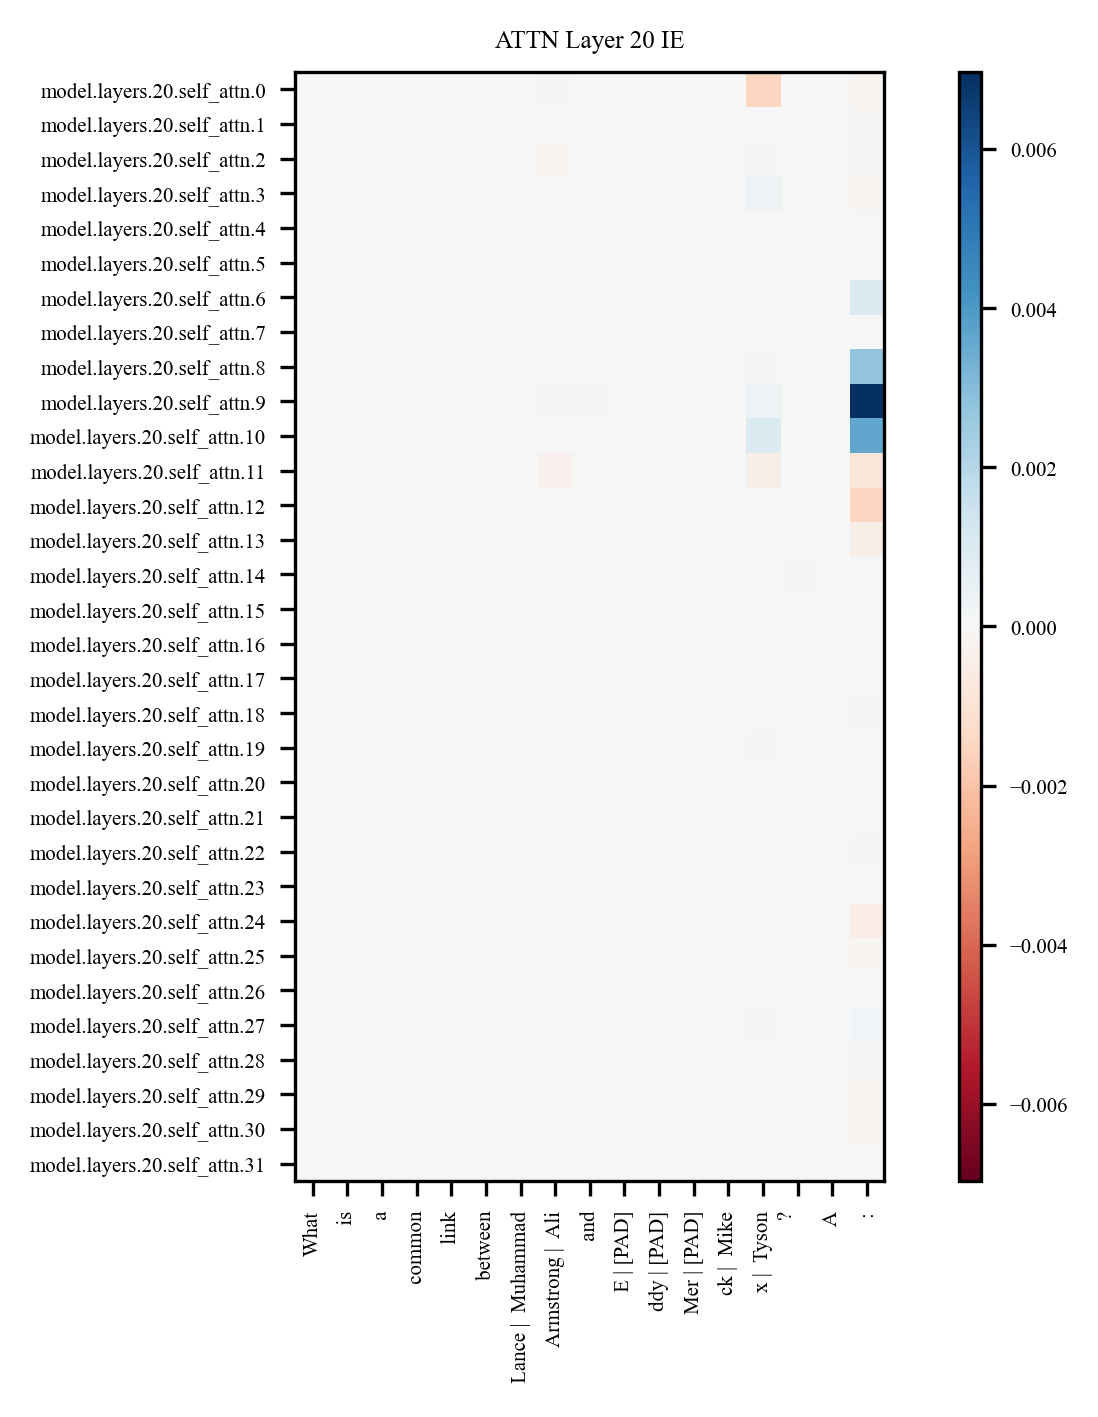

2024-08-27 18:08:58 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fae80a570d0>
2024-08-27 18:08:58 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2024-08-27 18:08:58 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2024-08-27 18:08:58 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


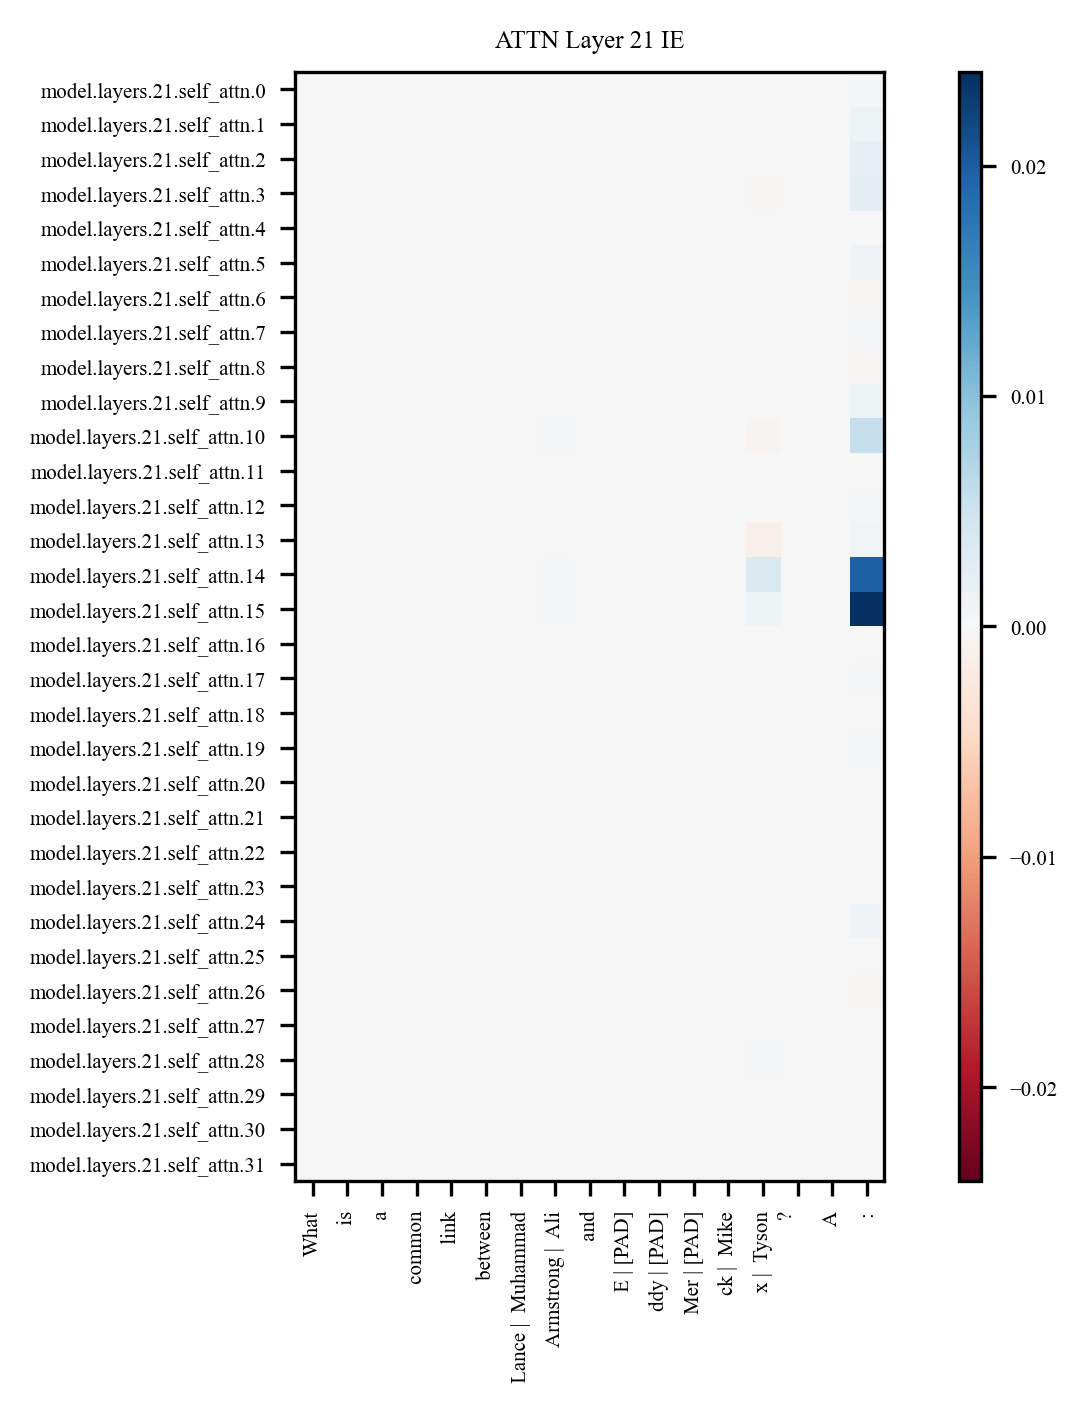

2024-08-27 18:08:59 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fae28759ed0>
2024-08-27 18:08:59 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2024-08-27 18:08:59 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2024-08-27 18:08:59 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


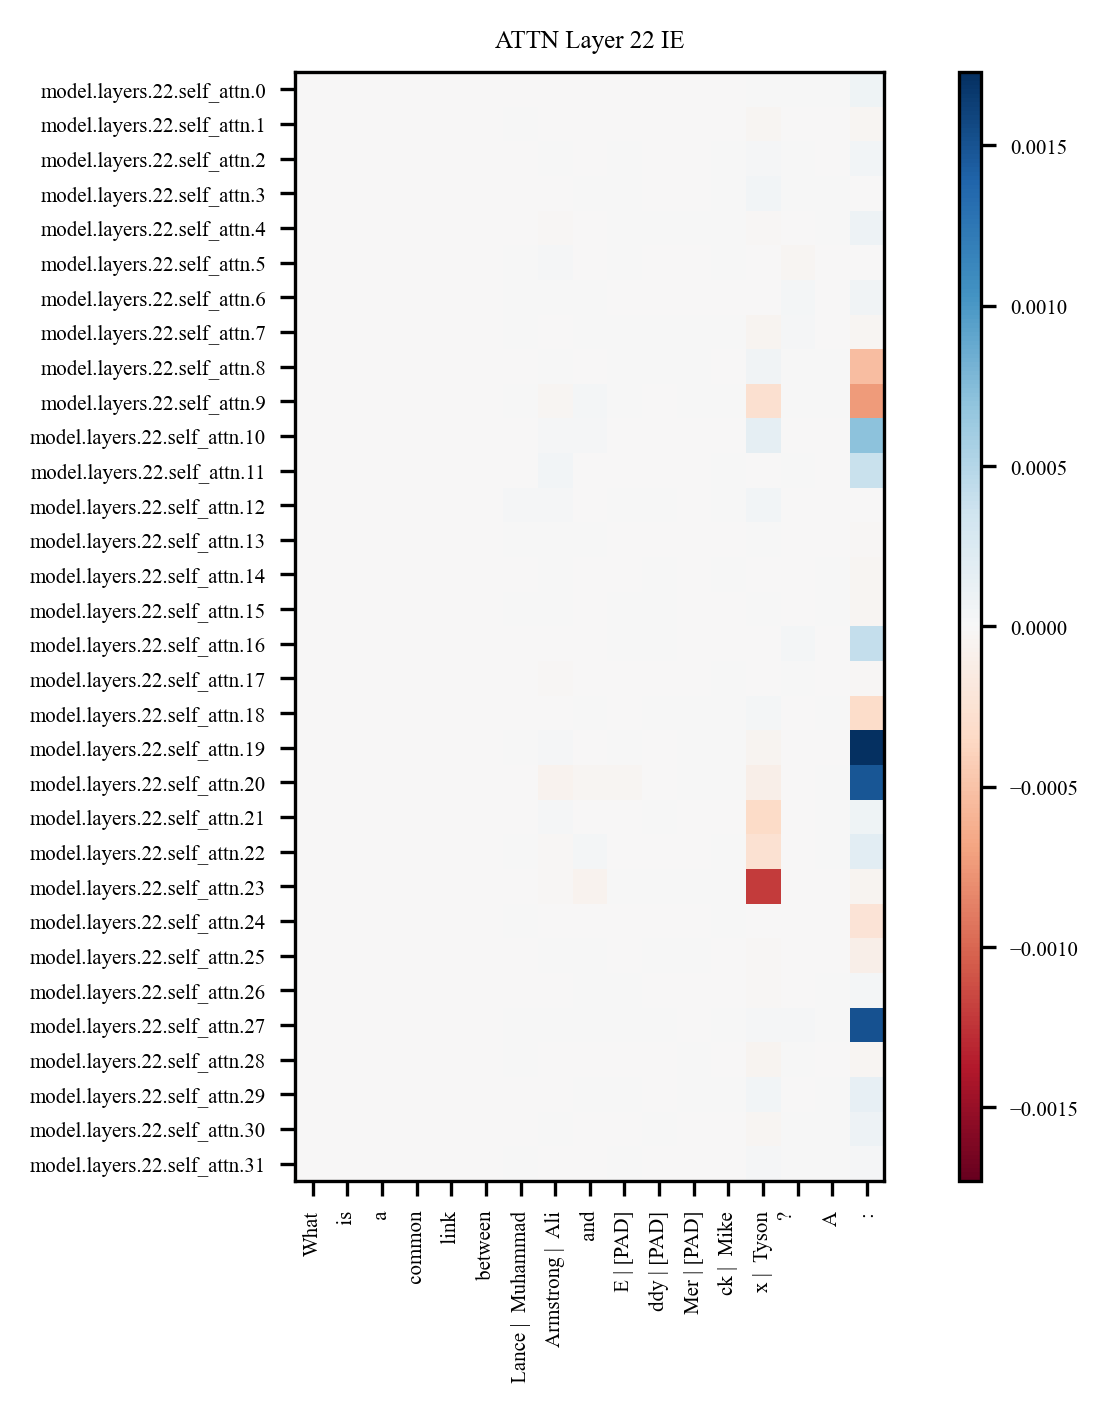

2024-08-27 18:08:59 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fad8fe035d0>
2024-08-27 18:08:59 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2024-08-27 18:08:59 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2024-08-27 18:08:59 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


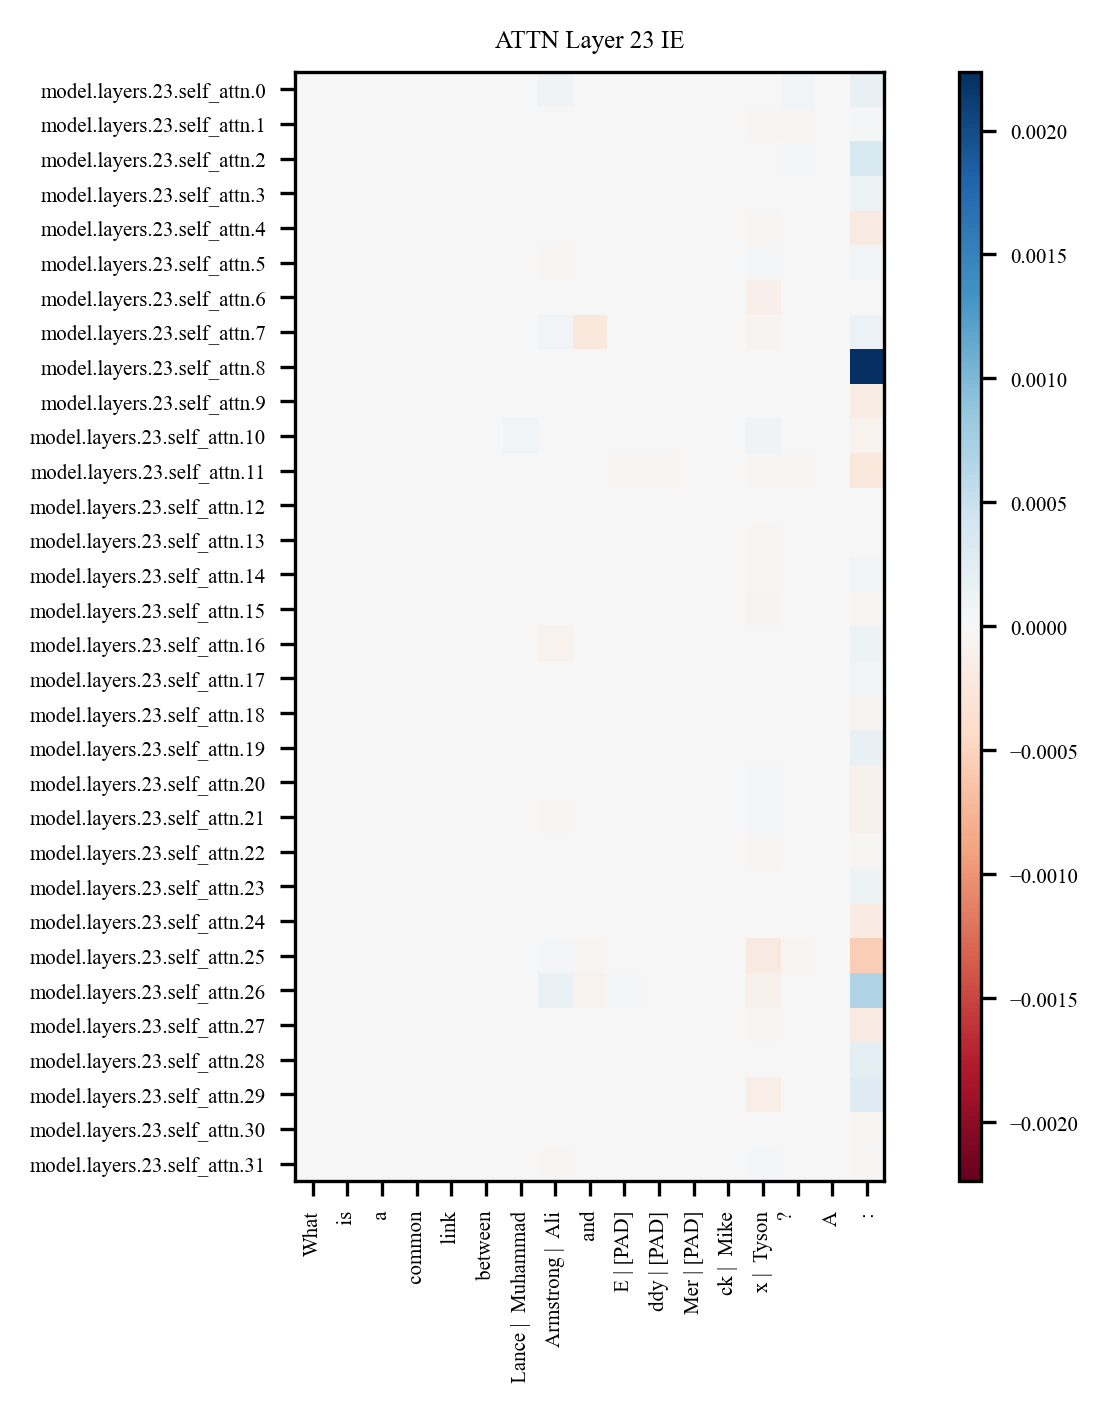

2024-08-27 18:09:00 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fad4e7ea350>
2024-08-27 18:09:00 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2024-08-27 18:09:00 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2024-08-27 18:09:00 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


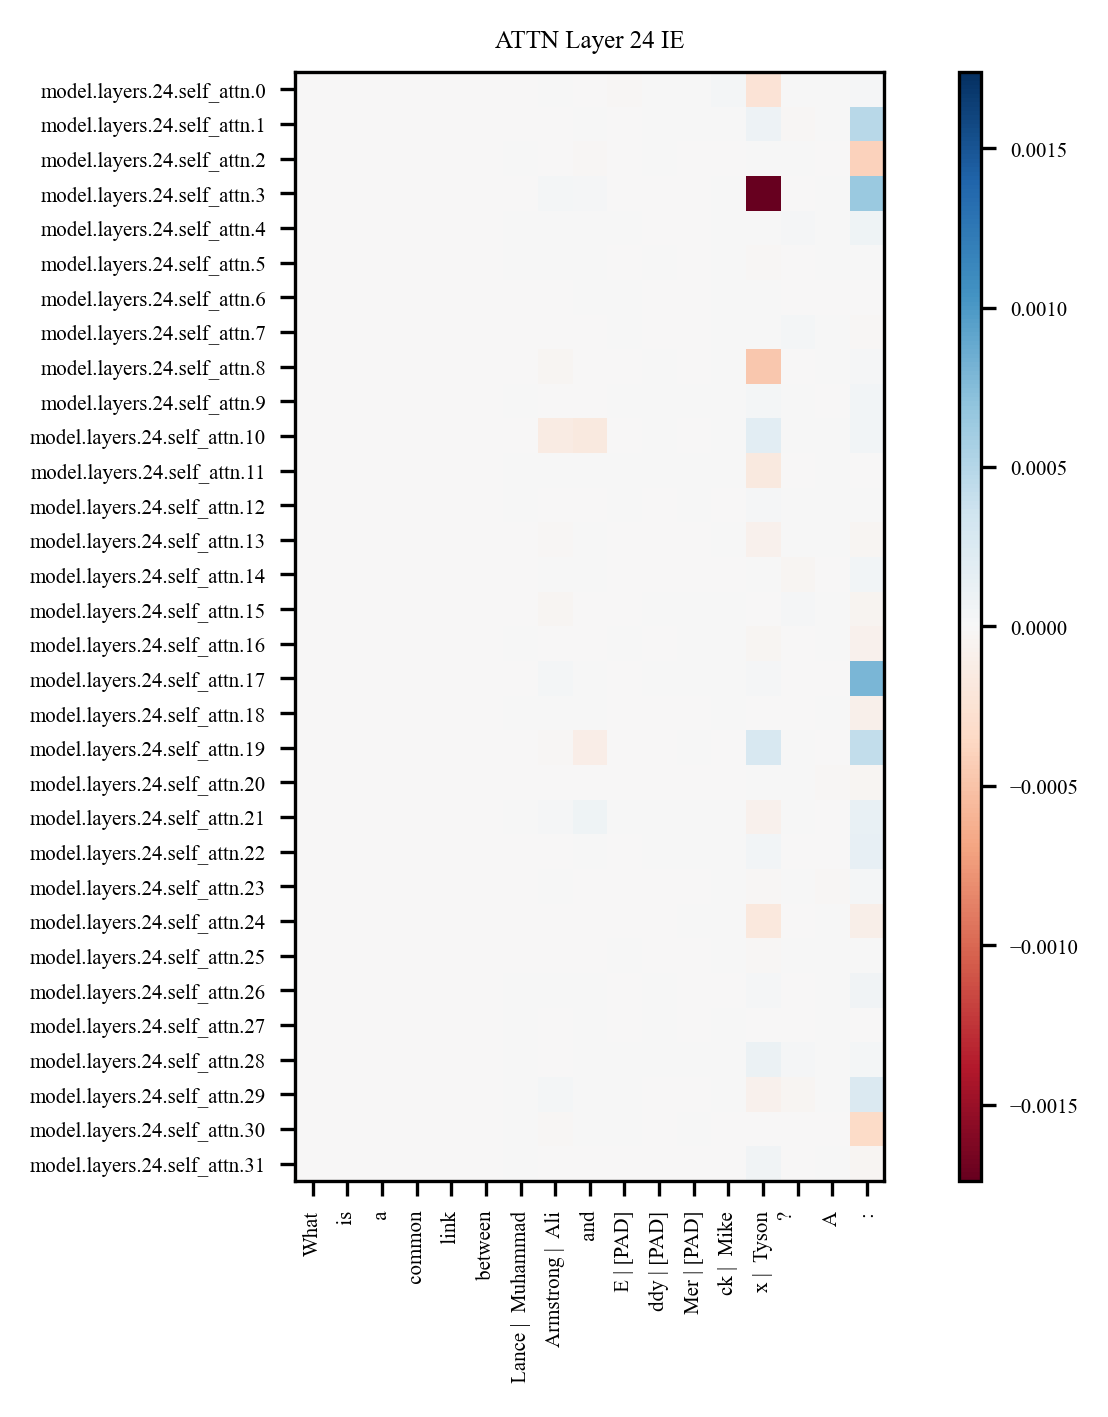

2024-08-27 18:09:00 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7faee42a5f90>
2024-08-27 18:09:00 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2024-08-27 18:09:00 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2024-08-27 18:09:00 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


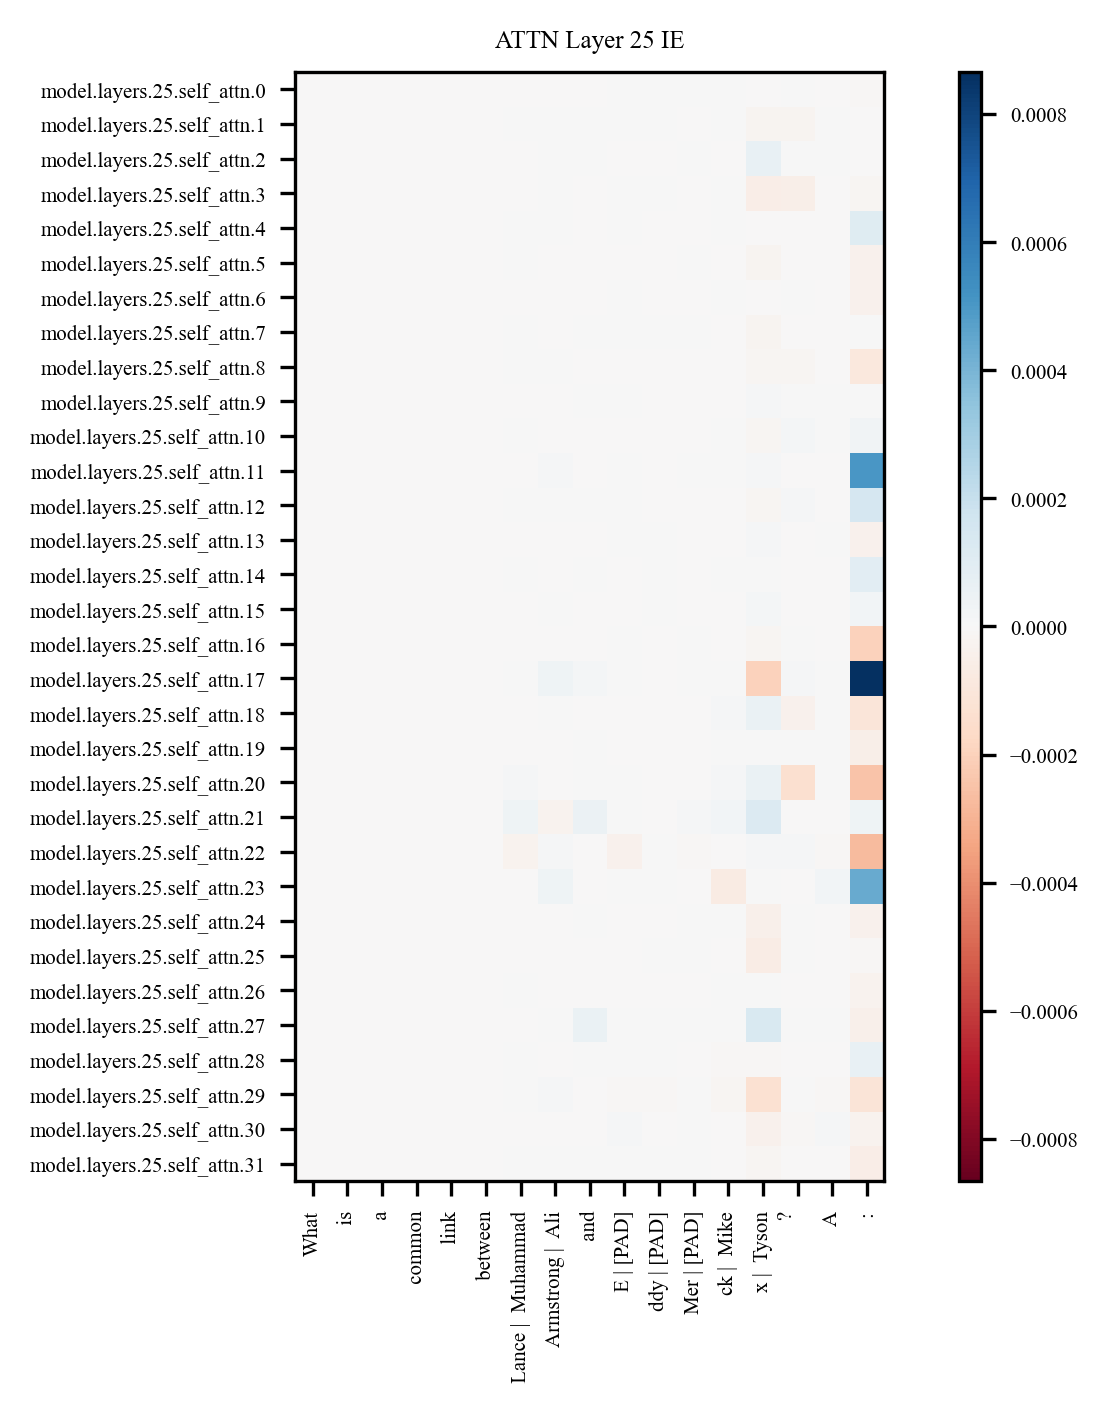

2024-08-27 18:09:01 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fae8199f990>
2024-08-27 18:09:01 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2024-08-27 18:09:01 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2024-08-27 18:09:01 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


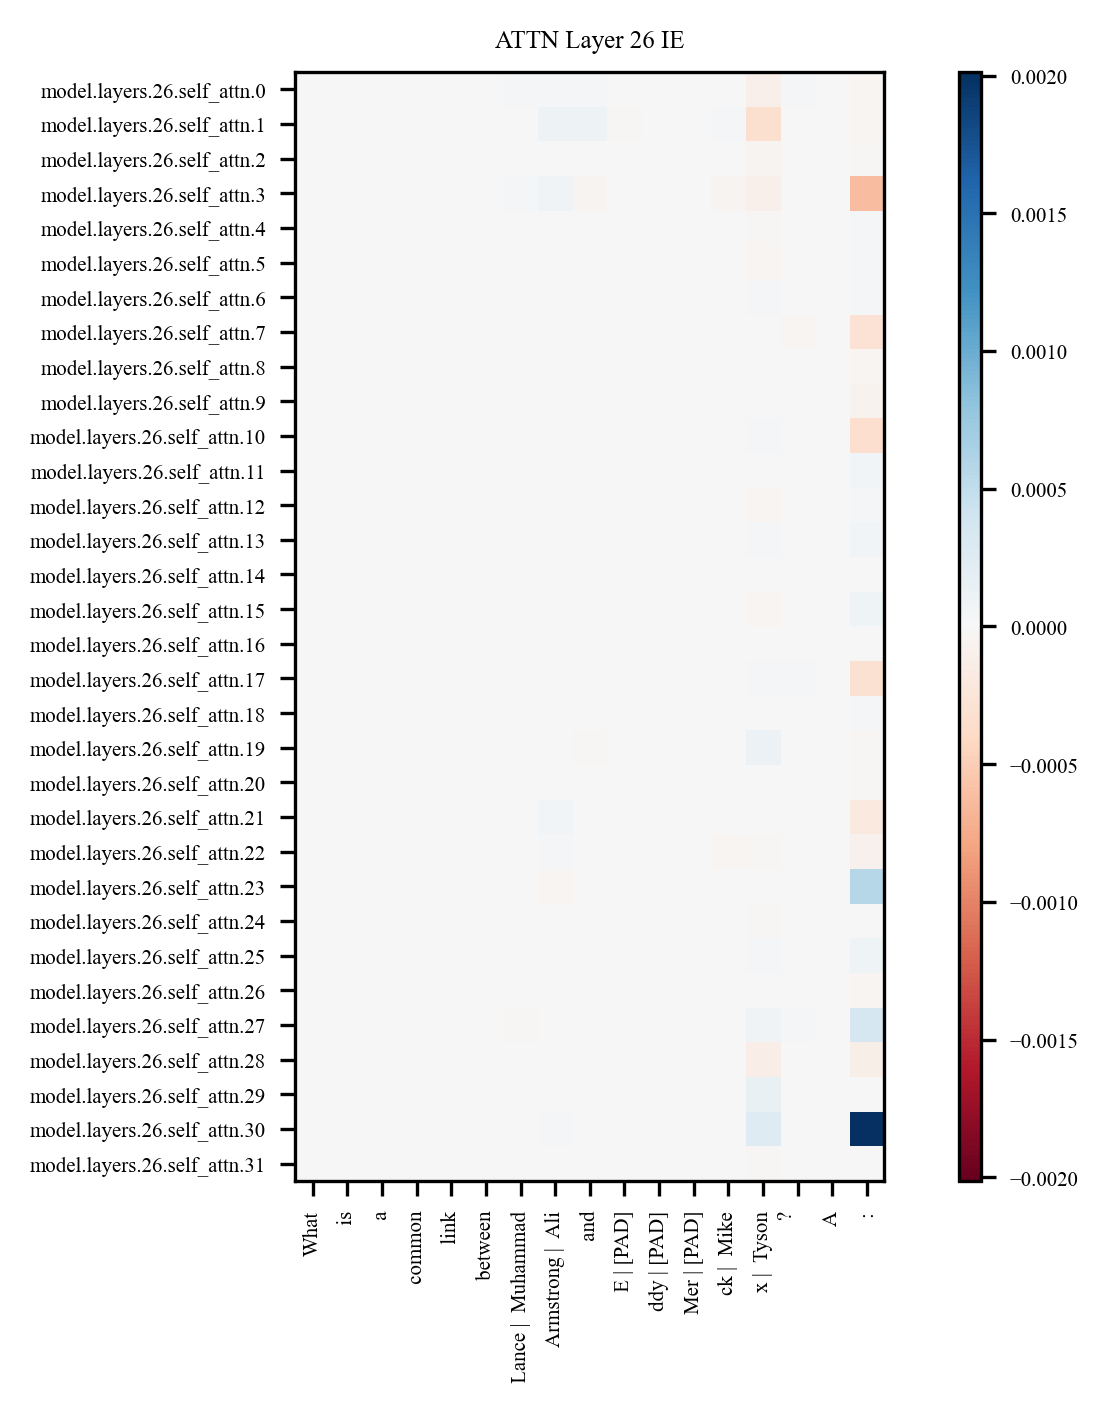

2024-08-27 18:09:01 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7facdbad1590>
2024-08-27 18:09:01 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2024-08-27 18:09:02 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2024-08-27 18:09:02 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


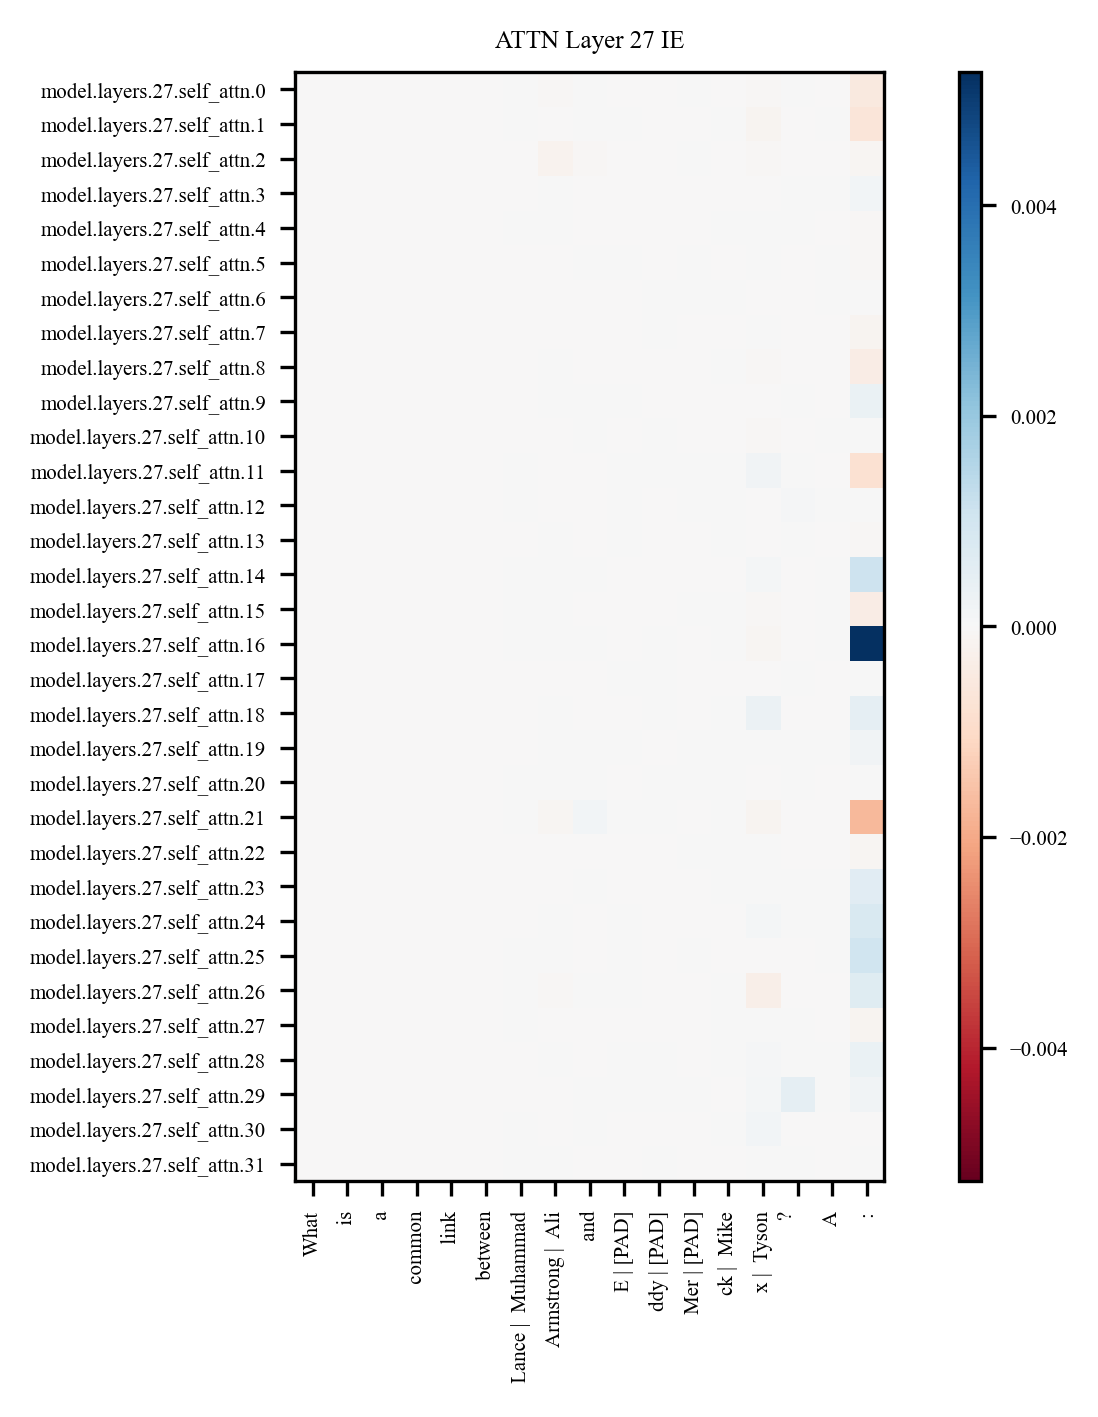

2024-08-27 18:09:02 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fae81f45d90>
2024-08-27 18:09:02 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2024-08-27 18:09:02 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2024-08-27 18:09:02 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


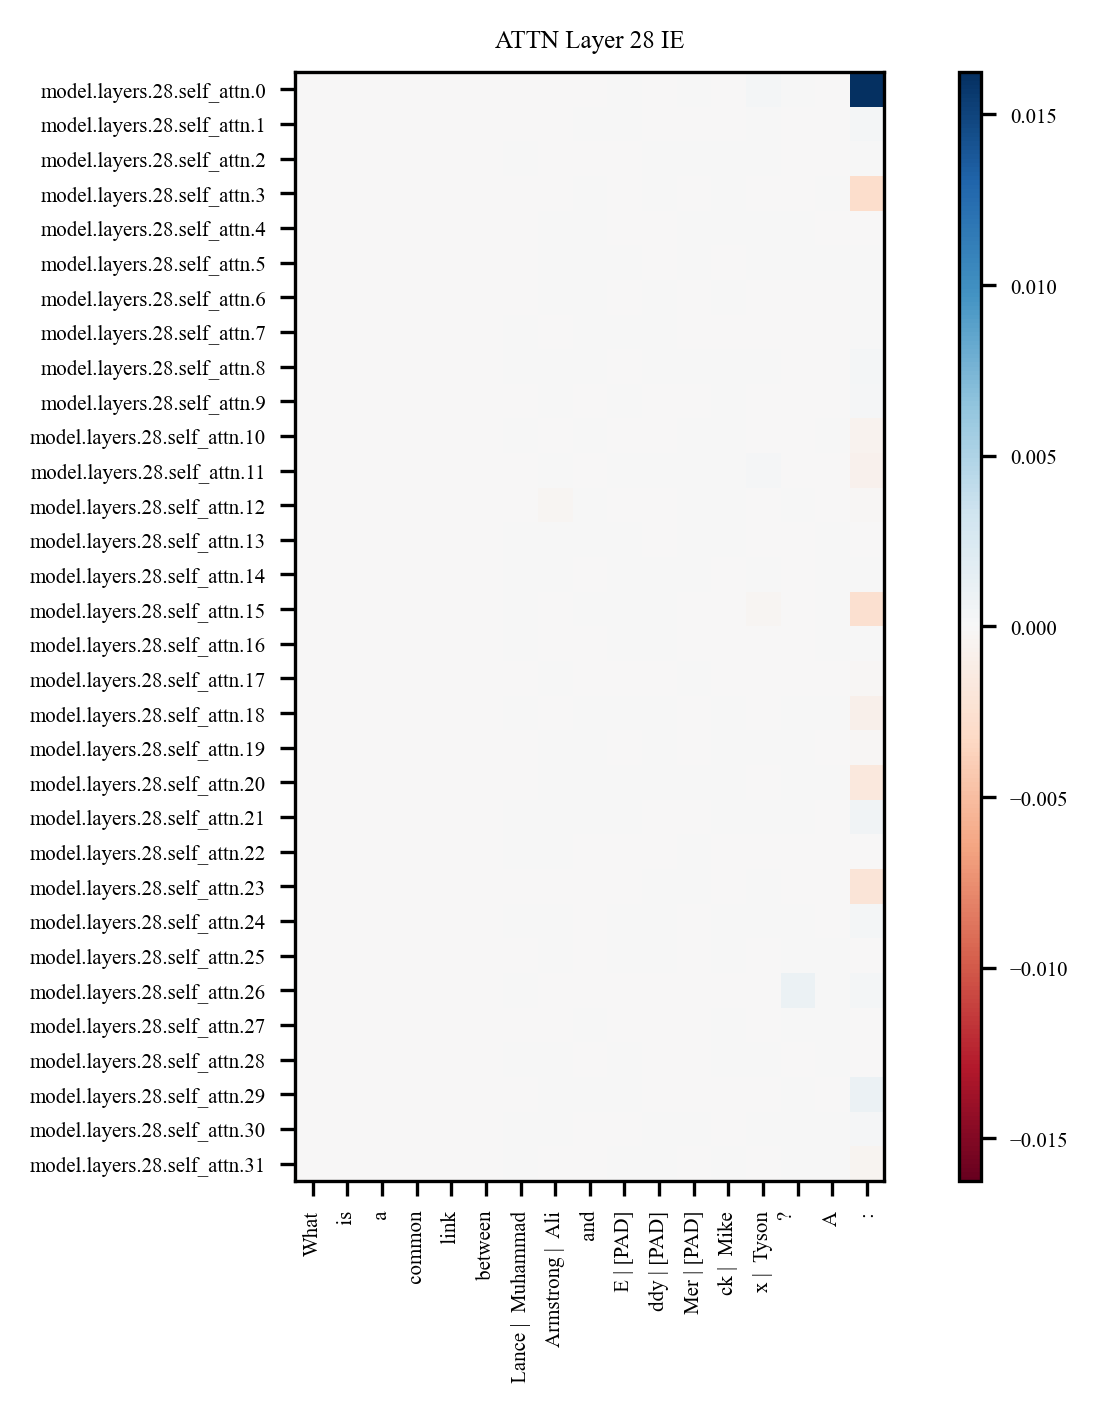

2024-08-27 18:09:02 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fadcef71590>
2024-08-27 18:09:03 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2024-08-27 18:09:03 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2024-08-27 18:09:03 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


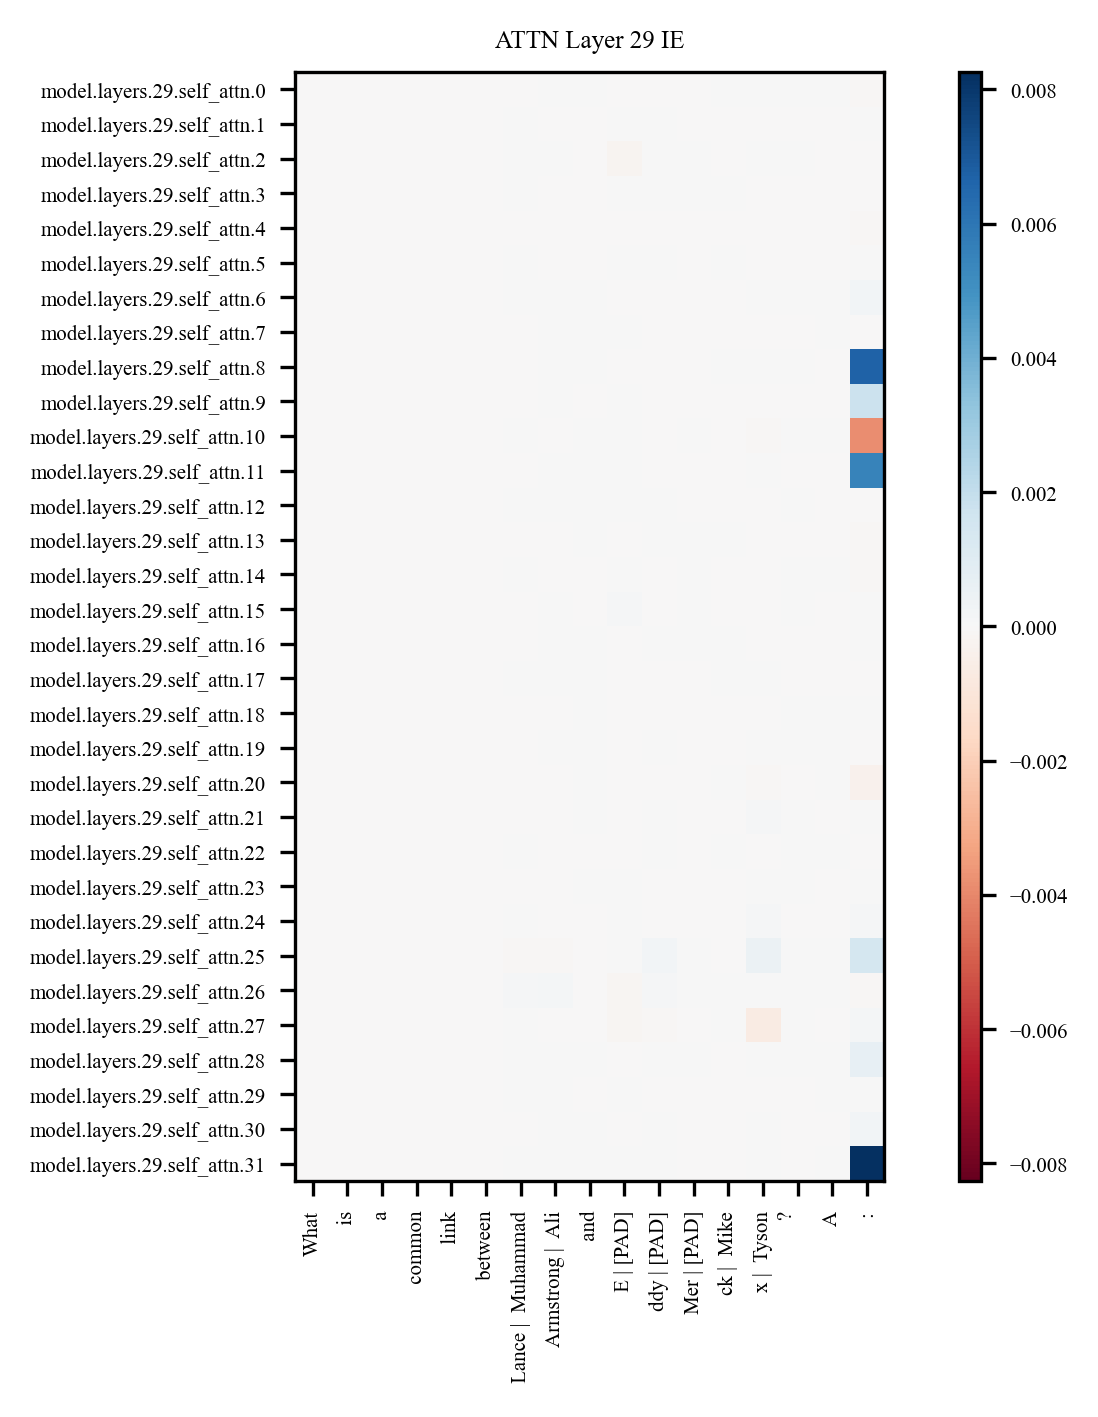

2024-08-27 18:09:03 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fad8e10e790>
2024-08-27 18:09:03 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2024-08-27 18:09:03 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2024-08-27 18:09:03 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


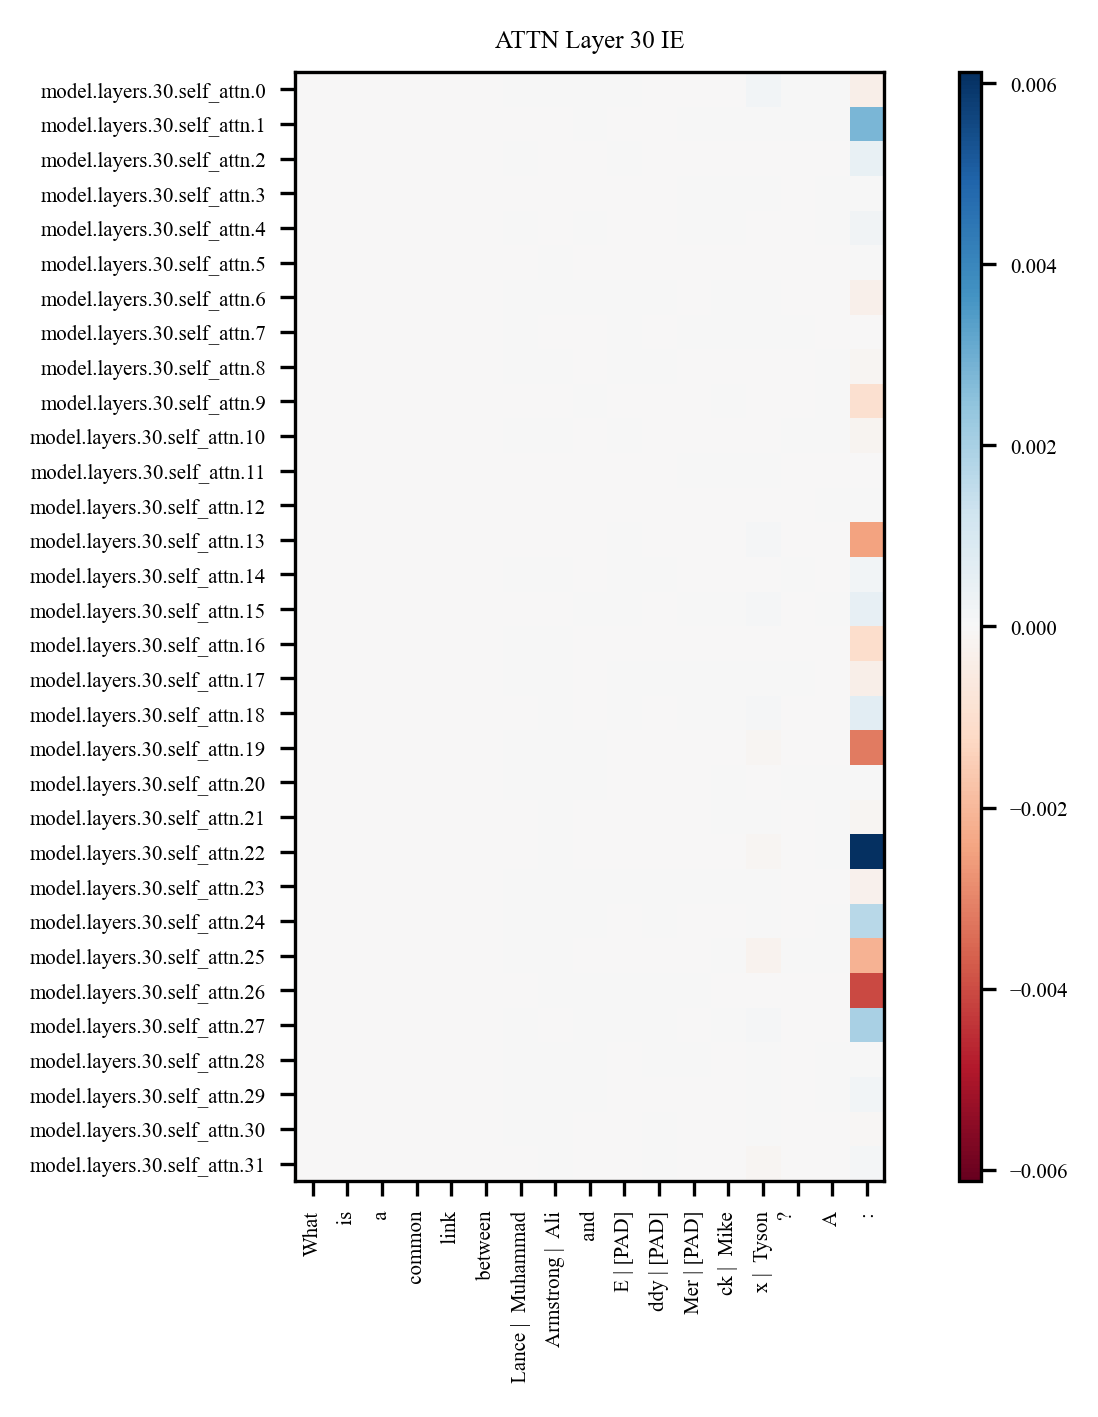

2024-08-27 18:09:03 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fadee7e7690>
2024-08-27 18:09:04 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2024-08-27 18:09:04 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2024-08-27 18:09:04 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


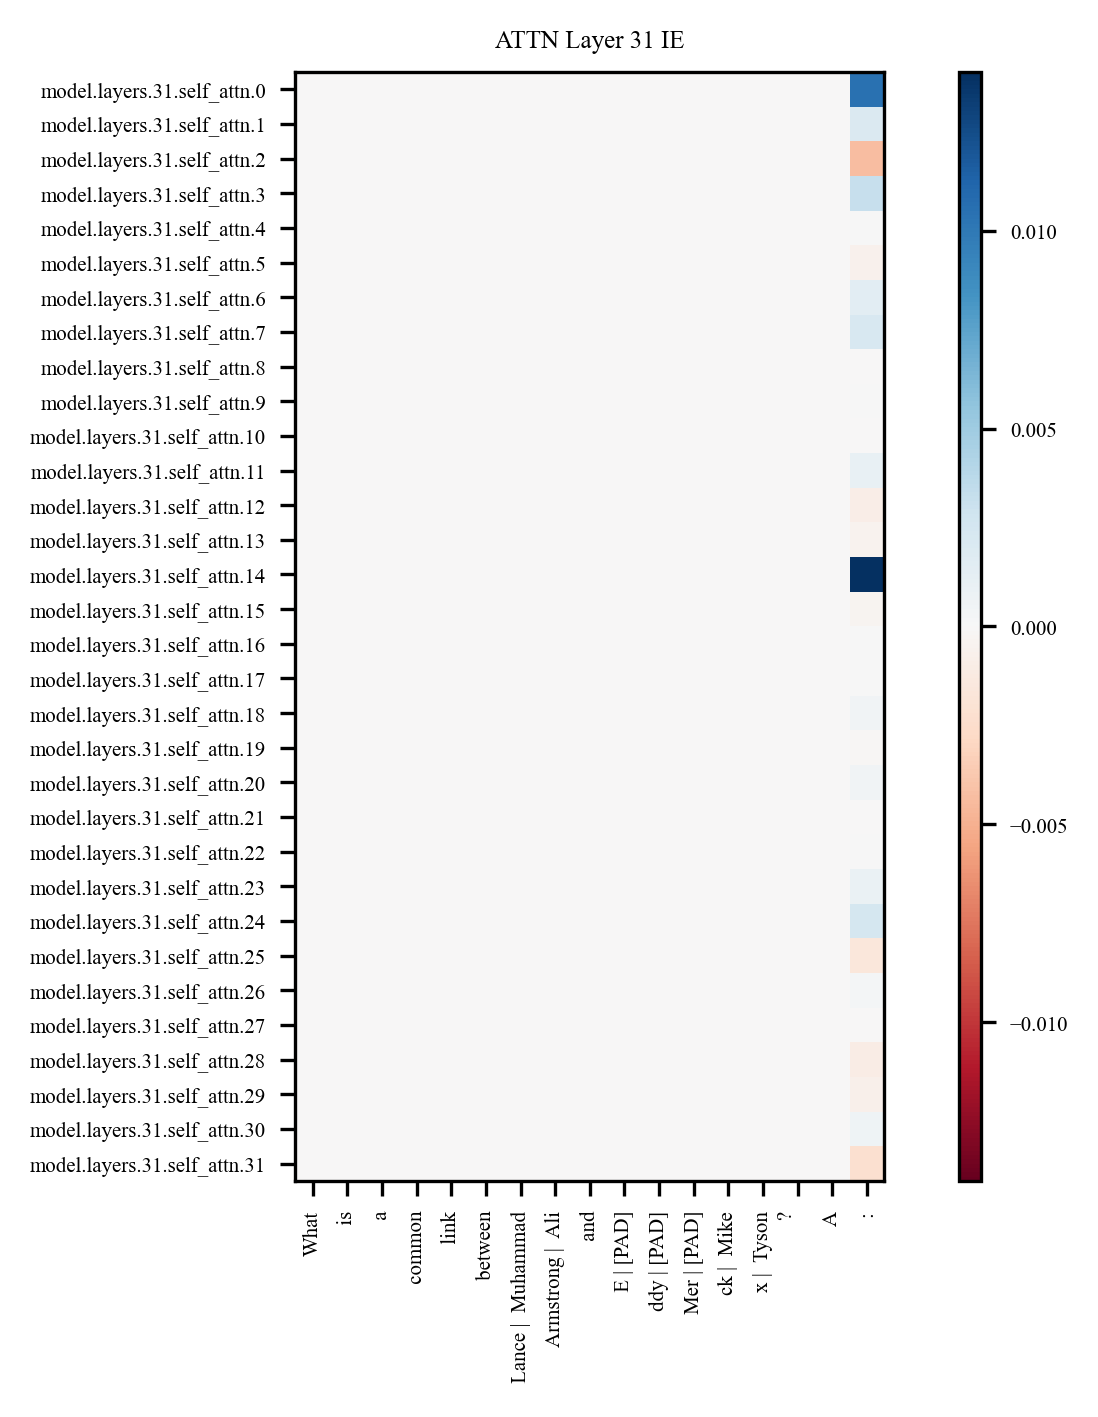

In [ ]:
# x_labels = [mt.tokenizer.decode(tok) for tok in patch_inputs.input_ids[0][query_start:]]
head_dir = os.path.join(save_dir, "heads")
os.makedirs(head_dir, exist_ok=True)

for l_idx in range(mt.n_layer):
    approx_effects, y_labels = get_layerwise_head_contributions(l_idx)
    plot_head_indirect_effect(
        layer_idx=l_idx,
        y_labels=y_labels,
        clean_tokens=[
            mt.tokenizer.decode(tok) for tok in clean_inputs.input_ids[0][query_start:]
        ],
        patch_tokens=[
            mt.tokenizer.decode(tok) for tok in patch_inputs.input_ids[0][query_start:]
        ],
        approx_effects=approx_effects,
        save_pdf=os.path.join(head_dir, f"layer_{l_idx}.pdf"),
    )